# IMPORTING LIBRARIES

In [5]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="3"
import numpy as np
import glob as glob
import SimpleITK as sitk
from tqdm import tqdm
import cv2
from datetime import datetime
import json
from scipy.interpolate import interp1d
from metrics import *
from scipy import ndimage
import pickle 
import time
from skimage.morphology import skeletonize
import matplotlib.pyplot as plt
from scipy.io import savemat
from skimage import measure, feature
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import imutils
from PIL import Image
import pickle
from skimage import morphology
from scipy.signal import argrelextrema
from scipy.signal import savgol_filter
from skimage.measure import label, regionprops, regionprops_table
import pandas as pd
import copy
from math import log10, floor
import shapely.geometry as shp
import math


#import utils as ut 
import teeth_segmentation as ts
import canal_segmentation as cs

# SUPPORTING FUNCTIONS

In [28]:
def get_full_scan(folder_path):

    files_List  = glob.glob(folder_path + '/**/*.dcm', recursive = True)
    itkimage = sitk.ReadImage(files_List[0])
    rows = int(itkimage.GetMetaData('0028|0010'))
    cols = int(itkimage.GetMetaData('0028|0011'))
    mn = 1000
    mx = 0
    for file in tqdm(files_List):
        itkimage = sitk.ReadImage(file)
        mn = np.min([mn, int(itkimage.GetMetaData('0020|0013'))])
        mx = np.max([mx, int(itkimage.GetMetaData('0020|0013'))])
    full_scan = np.ndarray(shape=(mx-mn+1,rows,cols), dtype=float, order='F')

    for file in tqdm(files_List):
        img, n = dcm_image(file)
        n = int(n)
        full_scan[n-mn,:,:] = img[0,:,:]

    return full_scan

def dcm_image(filename):
    global Algo_flag
    itkimage = sitk.ReadImage(filename)
    numpyImage = sitk.GetArrayFromImage(itkimage)
    ins = float(itkimage.GetMetaData('0020|0013'))
    #print(ins)
    #if ins==1.0:
    #    print("we here")
    #    print(itkimage.GetMetaData('0020|1041'))
    #    if int(itkimage.GetMetaData('0020|1041'))==153:
    #        Algo_flag = False
        
#     numpyImage = get_normalized(numpyImage,wc,wl)
    return numpyImage, ins

def get_normalized(scan,mn,mx):
    mn = max(mn,np.amin(scan))
    mx = min(mx,np.amax(scan))
    print('minimum: ',mn)
    print('maximum: ',mx)
    np.clip(scan, mn, mx, out=scan)
    d = mx - mn
    scan = (scan-mn)/d
    return scan



def plot_3d(image, threshold=100, alpha=0.5):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    p = p[:,:,::-1]
    
    verts, faces, norm, val = measure.marching_cubes_lewiner(p, threshold)

    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=alpha)
    face_color = [0.8, 0.2, 1]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()
    
def get_Filename(file):
    file = file.split('/')[-1]
    file = file.split('.')[0]
    return file


def normalize_3D_mask(scan):
    nscan = np.zeros((512, 512, scan.shape[2]), 'uint8')
    for i in tqdm(range(scan.shape[2])):
        s = scan[:,:,i]
        s = cv2.resize(s, (512, 512), interpolation=cv2.INTER_NEAREST)
        nscan[:,:,i] = s
    nnscan = np.zeros((512, 512, 512), 'uint8')
    
    for i in range(512):
        s = nscan[i,:,:]
        s = cv2.resize(s, (512, 512), interpolation=cv2.INTER_NEAREST)
        nnscan[i,:,:] = s
        
    return nnscan    



def normalize_3D_scan(scan):
    nscan = np.zeros((512, 512, scan.shape[2]), 'uint8')
    for i in tqdm(range(scan.shape[2])):
        s = scan[:,:,i]
        s = cv2.resize(s, (512, 512), interpolation=cv2.INTER_CUBIC)
        nscan[:,:,i] = s
    nnscan = np.zeros((512, 512, 512), 'uint8')
    
    for i in range(512):
        s = nscan[i,:,:]
        s = cv2.resize(s, (512, 512), interpolation=cv2.INTER_CUBIC)
        nnscan[i,:,:] = s
        
    return nnscan


def res_scan(nscan):
    desired_depth = 512
    desired_width = 512
    desired_height = 512
    current_depth = nscan.shape[0]
    current_width = nscan.shape[2]
    current_height = nscan.shape[1]
    depth_factor = desired_depth/current_depth
    width_factor = desired_width/current_width
    height_factor = desired_height/current_height
    nscan = ndimage.zoom(nscan, (depth_factor, height_factor, width_factor), order=1)
    return nscan

def res_mask(nmask):
    desired_depth = 512
    desired_width = 512
    desired_height = 512
    current_depth = nmask.shape[0]
    current_width = nmask.shape[2]
    current_height = nmask.shape[1]
    depth_factor = desired_depth/current_depth
    width_factor = desired_width/current_width
    height_factor = desired_height/current_height
    nmask = ndimage.zoom(nmask, (depth_factor, height_factor, width_factor), order=1, mode = 'nearest')
    return nmask


def readJsonLeft(file,sz):
    
    mask = np.zeros(sz)
    mask = mask.astype('uint8')

    with open(file) as json_file:
        data = json.load(json_file)   

    left_coords = data['annotation']['tooth']['Left']['coordinate']

    l = int(len(left_coords)/3)
    b = {}
    b[0] = np.zeros((l, 1))
    b[1] = np.zeros((l, 1))
    b[2] = np.zeros((l, 1))
    j = 0
    for x in range(0, len(left_coords), 3):
        b[0][j] = int(left_coords[x])
        b[1][j] = int(left_coords[x+1])
        b[2][j] = int(left_coords[x+2])
        j = j + 1

    for i in range(len(b[0])):
        mask[int(b[2][i]), int(b[1][i]), int(b[0][i])] = 1

    return mask
    
def readJsonRight(file,sz):
    
    mask = np.zeros(sz)
    mask = mask.astype('uint8')

    with open(file) as json_file:
        data = json.load(json_file)   

    left_coords = data['annotation']['tooth']['Right']['coordinate']

    l = int(len(left_coords)/3)
    b = {}
    b[0] = np.zeros((l, 1))
    b[1] = np.zeros((l, 1))
    b[2] = np.zeros((l, 1))
    j = 0
    for x in range(0, len(left_coords), 3):
        b[0][j] = int(left_coords[x])
        b[1][j] = int(left_coords[x+1])
        b[2][j] = int(left_coords[x+2])
        j = j + 1

    for i in range(len(b[0])):
        mask[int(b[2][i]), int(b[1][i]), int(b[0][i])] = 1

    return mask

    
def undesired_objects (image, Thresh=150):
    image = np.where(image>Thresh, 255, 0)
    image = image.astype('uint8')
    nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(image, connectivity=4)
    sizes = stats[:, -1]

    max_label = 1
    max_size = sizes[1]
    for i in range(2, nb_components):
        if sizes[i] > max_size:
            max_label = i
            max_size = sizes[i]

    img2 = np.zeros(output.shape)
    img2[output == max_label] = 255
    return img2


def offset(coordinates, distance):
    #coordinates = iter(coordinates)
    x1, y1 = coordinates[0]
    z = distance
    points = []
    for x2, y2 in coordinates:
        # tangential slope approximation
        try:
            slope = (y2 - y1) / (x2 - x1)
            # perpendicular slope
            pslope = -1/slope  # (might be 1/slope depending on direction of travel)
        except ZeroDivisionError:
            continue
        mid_x = (x1 + x2) / 2
        mid_y = (y1 + y2) / 2

        sign = ((pslope > 0) == (x1 > x2)) * 2 - 1

        # if z is the distance to your parallel curve,
        # then your delta-x and delta-y calculations are:
        #   z**2 = x**2 + y**2
        #   y = pslope * x
        #   z**2 = x**2 + (pslope * x)**2
        #   z**2 = x**2 + pslope**2 * x**2
        #   z**2 = (1 + pslope**2) * x**2
        #   z**2 / (1 + pslope**2) = x**2
        #   z / (1 + pslope**2)**0.5 = x

        delta_x = sign * z / ((1 + pslope**2)**0.5)
        delta_y = pslope * delta_x

        points.append((mid_x + delta_x, mid_y + delta_y))
        x1, y1 = x2, y2
    return points


def crop_sag(img,pix_x,pix_y,pix_z,crop=50):
    imgg=np.zeros((img.shape[0],img.shape[1]))
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if img[i,j,0] == 255 and img[i,j,1]==0:
                imgg[i,j]=1
    if np.any(imgg):
        #print('yes')
        area = 0
        contours,_=cv2.findContours(imgg.astype(np.uint8), cv2.RETR_LIST,cv2.CHAIN_APPROX_NONE)
        for contour in contours:
            area1 = cv2.contourArea(contour)
            if area1>area:
                cnt = contour
                area = area1
        try:
            M = cv2.moments(cnt)
            cx = int(M['m10']/M['m00'])
            cy = int(M['m01']/M['m00'])
        except:
            cx = contour[0][0][0]
            cy = contour[0][0][1]
            
        if cx-crop<0:
            cx1 = 0
        else:
            cx1 = cx-crop
        if cx+crop>img.shape[1]:
            cx2 = img.shape[1]
        else:
            cx2 = cx+crop
        if cy+crop > img.shape[0]:
            cy2 = img.shape[0]
            cy1 = cy2-(2*crop)
        else:
            cy1 = cy-crop
            cy2 = cy+crop
        cropped = img[cy1:cy2,cx1:cx2,:]
        #print(cy-crop,cy+crop,cx1,cx2)
        print(cropped.shape)
        cropped = set_scale(cropped,pix_x,pix_y,pix_z,'front')
        return cropped
    else:
        img = np.zeros((crop,crop))
        return img
    
def get_parasagittal(scan,mask,coords,skips=5,starting=0,count=10,gr_skips=25):

    #print(coords)
    #scan = copy.copy(scann)
    #print('scan before : ',np.unique(scan))
    #mini = np.amin(scan)
    #d = np.amax(scan) - mini
    #scan = (scan-mini)*255/d
    #print('scan: ',np.unique(scan))
    ysize = int(scan.shape[0]/2)
    xsize = int(scan.shape[1]/2)
    view = np.zeros((scan.shape[0],scan.shape[1]))
    perp_scan = []
    perpi_coords=[]
    z=0
    lll = 0 
    flag = False 
    for i in range(skips,coords.shape[0],skips):
        #print('hello')
        if z>=starting and z<starting+count:
            x1 = coords[i-skips,1]
            y1 = coords[i-skips,0]
            
            if i+gr_skips-1 < coords.shape[0]:
                x2 = coords[i-skips+gr_skips-1,1]
                y2 = coords[i-skips+gr_skips-1,0]
            else:
                x2 = coords[-1,1]
                y2 = coords[-1,0]
            
            #x2 = coords[i,1]
            #y2 = coords[i,0]
            x1 = x1-xsize
            y1 = ysize-y1
            x2 = x2-xsize
            y2 = ysize-y2
            m = (y2-y1)/(x2-x1)
            #y_bi = round((y2+y1)/2)
            #x_bi = round((x2+x1)/2)
            y_bi = y1
            x_bi = x1
            if not m==0:
                m_p = -1/m  
                intercept = (y_bi - (m_p*x_bi))
                #perp_coords = np.zeros((0,2),dtype = 'int')
                #if abs(m_p)<=1:
                py1 = round(m_p*(-xsize) + intercept)
                if (py1>-ysize) and (py1<=ysize):
                    px1 = round(-xsize)
                elif py1 <= -ysize:
                    py1 = round(-ysize+1)
                    px1 = round(py1 - intercept)/m_p
                else:
                    py1 = round(ysize)
                    px1 = round(py1 - intercept)/m_p
                py2 = round(m_p*(xsize-1) + intercept)
                if (py2>-ysize) and (py2<=ysize):
                    px2 = round(xsize-1)
                elif py2 <= -ysize:
                    py2 = round(-ysize+1)
                    px2 = round(py2 - intercept)/m_p
                else:
                    py2 = round(ysize)
                    px2 = round(py2 - intercept)/m_p
                px1 = round(px1+xsize)
                px2 = round(px2+xsize)
                py1 = round(ysize-py1)
                py2 = round(ysize-py2)
                x_bi = round(x_bi+xsize)
                y_bi = round(ysize-y_bi)
                xarray = np.array([px1,px2])
                yarray = np.array([py1,py2])
                #print(x)
                #print(
                if abs(m_p)<=1:
                    x_new = np.linspace(xarray.min(), xarray.max(),(xarray.max()-xarray.min()+1)).astype(np.uint)
                    f = interp1d(xarray, yarray, kind='linear')
                    y_smooth=f(x_new)
                else:
                    y_smooth = np.linspace(yarray.min() ,yarray.max(), (yarray.max()-yarray.min()+1)).astype(np.uint)
                    f = interp1d(yarray, xarray, kind='linear')
                    x_new = f(y_smooth)
                y_smooth = y_smooth.astype(np.uint)
                x_new = x_new.astype(np.uint)
                newarray = np.zeros_like(view)
                newarray[y_smooth,x_new] = 255
                points = np.argwhere(newarray>0)
                ind = np.lexsort((points[:,0], points[:,1])) 
                points = points[ind]
                point = np.abs(points[:,1]-x_bi).argmin()
                hypo = 200
                B = hypo*(math.sin(m_p))
                A = hypo*(math.cos(m_p))
                px1 = x_bi-(A/2)
                px2 = x_bi+(A/2)
                py1 = y_bi+(B/2)
                py2 = y_bi-(B/2)
                p1 = min(np.abs(points[:,1]-px1).argmin() , np.abs(points[:,0]-py1).argmin())
                p2 = max(np.abs(points[:,1]-px2).argmin() , np.abs(points[:,0]-py2).argmin())
                #point = np.argwhere(points[:,1]==x_bi)
                #point = point.min() + np.abs(points[int(point.min()):int(point.max()),0]-y_bi).argmin()
                perp_coords = points[round(p1):round(p2),:]
                    

            else:
                perp_coords = np.zeros((140,2),dtype = int) #140
                perp_coords[:,1] = round(x_bi+xsize)
                if ysize-y_bi-70 <=0:
                    array = np.arange(0,140).astype(np.uint16)
                    array = np.flip(array)
                    perp_coords[:,0] = array
                else:
                    array = np.arange((ysize-y_bi)-70,(ysize-y_bi)+70).astype(np.uint16) ##20  120
                    array = np.flip(array)
                    perp_coords[:,0] = array
            perpi_coords.append(perp_coords)
            perp = np.zeros((scan.shape[0],perp_coords.shape[0]),int)
            perp_m = np.zeros((scan.shape[0],perp_coords.shape[0]),int)
            for x in range(perp_coords.shape[0]):
                #print(perp_coords[x,1])
                perp[:,x] = scan[:,perp_coords[x,0],perp_coords[x,1]]
                perp_m[:,x] = mask[:,perp_coords[x,0],perp_coords[x,1]].astype(np.uint16)
                view[perp_coords[x,0],perp_coords[x,1]]=255
            
            perp_3d = np.zeros((perp.shape[0],perp.shape[1],3),int)
            perp_3d[:,:,0] = np.where(perp_m==1,255,perp)
            perp_3d[:,:,1] = np.where(perp_m==1,0,perp)
            perp_3d[:,:,2] = np.where(perp_m==1,0,perp)

            #perp_m_i = 1-perp_m
            #perp_3d[:,:,0]=perp[:,:]*perp_m_i[:,:] + perp_m[:,:]*255
            #perp_3d[:,:,1]=perp[:,:]*perp_m_i[:,:]
            #perp_3d[:,:,2]=perp[:,:]*perp_m_i[:,:]
            perp_scan.append(perp_3d)
            lll = lll+1
        z=z+1

    #print(len(perp_scan))
    return perp_scan,view

def get_panoramic(scan,mask,arch,coords,ss=0,length=2 ,cond=False,skips=5):
    print(scan.shape)
    print(mask.shape)
    print(arch.shape)
    view = np.zeros((arch.shape[0],arch.shape[1]))
    view_without = np.zeros((arch.shape[0],arch.shape[1]))
    xsize = round(arch.shape[1]/2)
    ysize = round(arch.shape[0]/2)
    without_scan = np.zeros((scan.shape[0],0))
    pano_mask = np.zeros((scan.shape[0],0),int)
    for i in range(0,coords.shape[0]-1,1):
        #teeth_flag = False
        x1 = coords[i,1]
        y1 = coords[i,0]
        if i+skips-1 < coords.shape[0]:
            x2 = coords[i+skips-1,1]
            y2 = coords[i+skips-1,0]
        else:
            x2 = coords[-1,1]
            y2 = coords[-1,0]
        x1 = x1-xsize
        y1 = ysize-y1
        x2 = x2-xsize
        y2 = ysize-y2
        m = (y2-y1)/(x2-x1)
        y_bi = y1
        x_bi = x1
        #if np.any(teeth_ax[:,x_bi+xsize])>0:
        #    teeth_flag = True
        if (not m==0):
            m_p = -1/m  
            intercept = (y_bi - (m_p*x_bi))
            perp_coords = np.zeros((0,2),dtype = 'int')
            #teeth=np.zeros((0,2),dtype = 'int')
            without = np.zeros((0,2),dtype = 'int')
            if abs(m_p)<=1:
                for x in range(x_bi-ss,x_bi+ss):
                    y = round(m_p*x + intercept)
                    xx = round(x+xsize)
                    yy= round(ysize-y)
                    if yy>=scan.shape[1] or yy<0 or xx>=scan.shape[1] or xx<0:
                        continue
                    else:
                        perp_coords = np.vstack((perp_coords,[yy,xx]))
                        #if x<=x_bi+10 and x>=xx_bi+10:
                        #    teeth = np.vstack((teeth,[yy,xx]))
                        if x<=x_bi+length and x>=x_bi-length:
                            without = np.vstack((without,[yy,xx]))
            else:
                for y in range(y_bi-ss,y_bi+ss):
                    x = round((y-intercept)/m_p)
                    xx = round(x+xsize)
                    yy= round(ysize-y)
                    if yy>=scan.shape[1] or yy<0 or xx>=scan.shape[1] or xx<0:
                        continue
                    else:
                        perp_coords = np.vstack((perp_coords,[yy,xx]))
                        #if x<=x_bi+10 and x>=xx_bi+10:
                        #    teeth = np.vstack((teeth,[yy,xx]))
                        if y<=y_bi+length and y>=y_bi-length:
                            without = np.vstack((without,[yy,xx]))


        else:
            if cond==True:
                perp_coords = np.zeros((int(ss*3),2),dtype = int)
                without = np.zeros((int(length*3),2),dtype = int)
                perp_coords[:,1] = round(x_bi+xsize)
                without[:,1] = round(x_bi+xsize)
                if (ysize-y_bi-(2*ss))<0:
                    ran1 = 0
                    ran2 = int(3*ss)
                    perp_coords[:,0] = np.arange(ran1,ran2).astype(np.uint16)
                else:
                    ran1 = int(ysize-y_bi-(2*ss))
                    ran2 = int(ysize-y_bi+ss)
                    perp_coords[:,0] = np.arange(ran1,ran2).astype(np.uint16)
                if (ysize-y_bi-(2*length))<0:
                    ran_1 = 0
                    ran_2 = int(3*length)
                else:
                    ran_1 = int(ysize-y_bi-(2*length))
                    ran_2 = int(ysize-y_bi+length)
                #print('what is happening')
            else:
                lolo = False
                perp_coords = np.zeros((int(ss*2),2),dtype = int)
                #perp_coords = np.zeros((int(ss*3),2),dtype = int)
                without = np.zeros((int(length*2),2),dtype = int)
                perp_coords[:,1] = round(x_bi+xsize)
                #perp_coords[:,1] = round(x_bi+xsize)
                without[:,1] = round(x_bi+xsize)
                if (ysize-y_bi-(ss))<0:
                    ran1 = 0
                    ran2 = int(2*ss)
                    perp_coords[:,0] = np.arange(ran1,ran2).astype(np.uint16)
                else:
                    ran1 = int(ysize-y_bi-(ss))
                    ran2 = int(ysize-y_bi+ss)
                    perp_coords[:,0] = np.arange(ran1,ran2).astype(np.uint16)
                if (ysize-y_bi-(length))<0:
                    ran_1 = 0
                    ran_2 = int(2*length)
                    without[:,0] = np.arange(ran_1,ran_2).astype(np.uint16)
                else:
                    ran_1 = int(ysize-y_bi-(length))
                    ran_2 = int(ysize-y_bi+length)
                    array =  np.arange(ran_1,ran_2).astype(np.uint16)
                    without[:,0] = array
        #perp = np.zeros((scan.shape[0],perp_coords.shape[0]))
        perp_without = np.zeros((scan.shape[0],without.shape[0]))
        perp_m = np.zeros((scan.shape[0],perp_coords.shape[0]),int)
        for x in range(perp_coords.shape[0]):
            #perp[:,x] = scan[:,perp_coords[x,0],perp_coords[x,1]]
            perp_m[:,x] = mask[:,perp_coords[x,0],perp_coords[x,1]].astype(np.uint8)
            view[perp_coords[x,0],perp_coords[x,1]]=255
        for x in range(without.shape[0]):
            perp_without[:,x] = scan[:,without[x,0],without[x,1]]
            view_without[without[x,0],without[x,1]]=255
        #perp_mip = np.amax(perp,axis=1)
        without_mip = np.amax(perp_without,axis=1)
        perp_m_mip = np.amax(perp_m,axis=1)
        #pano_scan = np.column_stack((pano_scan,perp_mip))
        without_scan = np.column_stack((without_scan,without_mip))
        pano_mask = np.column_stack((pano_mask,perp_m_mip))
    without_scan = np.fliplr(without_scan)
    pano_mask = np.fliplr(pano_mask)
    pano_mask = pano_mask.astype(np.uint8)
    ker = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(9,9)) 
    pano_mask = ndimage.morphology.binary_closing(pano_mask,ker)
    pano_mask = pano_mask.astype(np.uint8)
    #pano_scan = pano_scan.astype(np.uint8)
    points = np.argwhere(pano_mask>0)
    start = int(np.amin(points[:,0]) -30)
    end = int(np.amax(points[:,0]) +30)
    pano_view=np.zeros((without_scan.shape[0],without_scan.shape[1],3),dtype = int)
    #pano_view[:,:,0] = np.where(pano_mask>0,255,without_scan)
    #pano_view[:,:,1] = np.where(pano_mask>0,0,without_scan)
    #pano_view[:,:,2] = np.where(pano_mask>0,0,without_scan)
    
    
    #plt.figure(figsize = (30,10))
    #plt.imshow(pano_view,'gray')
    #plt.imshow(pano_view,'gray')
    
    minimum = np.amin(without_scan)
    diff = np.amax(without_scan) - minimum
    without_scan = (without_scan-minimum)*255/diff
    without_scan = without_scan.astype(np.uint)

    con_ones_L = np.zeros_like(pano_mask)
    con_ones_R = np.zeros_like(pano_mask)
    con_zeros = 1 - pano_mask
    con_ones_L[:,int(pano_mask.shape[1]/2):] = pano_mask[:,int(pano_mask.shape[1]/2):]
    con_ones_R[:,:int(pano_mask.shape[1]/2)] = pano_mask[:,:int(pano_mask.shape[1]/2)]
    con_ones_L = np.where(con_ones_L>0,1,0)
    con_ones_R = np.where(con_ones_R>0,1,0)
    
    pano_view[:,:,0] = without_scan*con_zeros + con_ones_L*255
    pano_view[:,:,2] = without_scan*con_zeros + con_ones_R*255
    pano_view[:,:,1] = without_scan*con_zeros
    
    #pano_view = pano_view[start:end,:]
    #without_scan = without_scan[start:end,:]
    
    return pano_view,without_scan,view_without,view

def dental_type2(scan,teeth_mask,msk):
    gscan = copy.copy(scan)
    gscan = get_normalized(gscan, -500, 4500)*255 # scans of 78: whole gum
    gscan = gscan.astype('uint8')  
    teeth_mask1 = np.amax(teeth_mask,axis = 1)
    teeth_mask1 = teeth_mask1>0
    teeth_mask1 = ndimage.morphology.binary_fill_holes(teeth_mask1)
    ker = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(25,25)) 
    teeth_mask1 = ndimage.morphology.binary_closing(teeth_mask1,ker)#
    teeth_mask1 = morphology.remove_small_objects(teeth_mask1, min_size=500)
    
    new_c = np.argwhere(teeth_mask1>0)
    start = np.amin(new_c[:,0])
    end = np.amax(new_c[:,0])
    cropped_scan = gscan[start:end,:,:]
    mask = copy.copy(msk)
    mask = mask[start:end,:,:]
    #plt.figure(figsize = (10,10))
    d_mips = np.amax(cropped_scan,axis=0)
    #plt.imshow(teeth_mask1, 'gray')
    thres = d_mips>120 #100 
    thres = morphology.remove_small_objects(thres, min_size=200)
    thres = ndimage.morphology.binary_fill_holes(thres)
    #plt.imshow(thres,'gray')
    ker = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(25,25)) 
    thres = ndimage.morphology.binary_closing(thres,ker)
    #plt.imshow(thres,'gray')
    contours,_ = cv2.findContours(thres.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    peri=d_mips.shape[0]
    num=0
    for cnt in contours:
        _,y,_,_ = cv2.boundingRect(cnt)
        #print(y)
        if y<peri:
            peri = y
            index = num
        num = num+1
    #print(index)
    thres = np.zeros((d_mips.shape[0],d_mips.shape[0]),dtype = np.uint8)
    thres = cv2.drawContours(thres, contours[index], -1, 255, 1)
    thres=thres>0
    thres = ndimage.morphology.binary_fill_holes(thres)
    points = np.argwhere(thres>0)
    row_cut1 = np.amin(points[:,0])
    row_cut2 = np.amax(points[:,0])
    col_cut1 = np.amin(points[:,1])
    col_cut2 = np.amax(points[:,1])
    s_mips = d_mips[row_cut1-10:row_cut2+10,col_cut1-10:col_cut2+10]
    mini = np.amin(s_mips)
    maxi = np.amax(s_mips)
    d = maxi-mini
    s_mips = (s_mips-mini)/d
    #mask = mask.astype(np.uint8)
    #mask = np.amax(mask,axis=0)
    #mask = mask[row_cut1-10:row_cut2+10,col_cut1-10:col_cut2+10]
    #mask = mask.astype(np.uint8)
    #con_ones_L = np.zeros_like(mask)
    #con_ones_R = np.zeros_like(mask)
#     con_ones_L[:,:255] = 0
#     con_ones_R[:,256:] = 0
    #con_zeros = 1 - mask
    #con_ones_L[:,:int(mask.shape[1]/2)] = mask[:,:int(mask.shape[1]/2)]
    #con_ones_R[:,int(mask.shape[1]/2):] = mask[:,int(mask.shape[1]/2):]
    #axial = np.zeros([s_mips.shape[0],s_mips.shape[1],3],int)
    #axial[:,:,0] = s_mips*con_zeros*255 + con_ones_L*255
    #axial[:,:,2] = s_mips*con_zeros*255 + con_ones_R*255
    #axial[:,:,1] = s_mips*con_zeros*255  
    axial = s_mips*255
    #plt.figure(figsize = (10,10))
    #plt.imshow(d_mips,'gray')
    #plt.imshow(thres, 'gray')#,alpha=0.5)
    teethm = np.amax(teeth_mask,axis=0)
    teethm = teethm>0
    teethm = ndimage.morphology.binary_fill_holes(teethm)
    ker = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(25,25)) 
    teethm = ndimage.morphology.binary_closing(teethm,ker)#
    teethm = morphology.remove_small_objects(teethm, min_size=200)
    
    #contours,_ = cv2.findContours(teethm.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    #teethm = np.zeros_like(teethm)
    #teethm = teethm.astype(np.uint8)
    #print(contours)
    #print('length',len(contours))
    #for cnt in contours:
    #    print('we in')
    #    epsilon = 0.05*cv2.arcLength(cnt,True)
    #    approx = cv2.approxPolyDP(cnt,epsilon,True)
    #    print(approx)
    #    teethm = cv2.drawContours(teethm, approx, -1, 255, 1)
    #teethm = teethm>0
    #teethm = ndimage.morphology.binary_fill_holes(teethm)
    
    
    #plt.figure(figsize = (10,10))
    #plt.imshow(teethm,'gray')
    #thres = morphology.skeletonize(thres)
    teeth = copy.copy(teethm)
    teeth = skeletonize(teeth)
    #plt.figure(figsize = (10,10))
    #plt.imshow(teeth_sk,'gray')
    points = np.argwhere(teeth>0)
    p = np.argmin(points[:,0])
    [r1,c1] = points[p]
    #print(r1,c1)
    p = np.argmin(points[:,1])
    [rl,cl] = points[p]
    p = np.argmax(points[:,1])
    [rr,cr] = points[p]
    #print(rl,cl)
    #print(rr,cr)
    flattened = np.zeros((0,1))
    l=0
    for i in range(cl,cr+1,1):
        a = np.argmax(teeth[:,i])
        l = l+1
        flattened = np.vstack((flattened,a))
    #plt.plot(flattened)
    smoothed = savgol_filter(flattened.flatten(),95,3) #79
    archteeth = np.zeros_like(teeth)
    checkk = np.empty((0,2),dtype = int)
    j=0
    for i in range(cl,cr+1,1):
        coord = round(smoothed[j])
        archteeth[coord,i]=255
        checkk = np.vstack((checkk,[i,coord]))
        j=j+1

    lost = copy.copy(archteeth)
    points = np.argwhere(teethm>0)
    p1 = np.amin(points[:,0])
    p2 = np.amin(checkk[:,1])
    p = round((p2-p1)*1/2)
    parallel = offset(checkk, p)
    t = [x[0] for x in parallel]
    s = [x[1] for x in parallel]
    t = np.asarray(t)
    s = np.asarray(s)
    t = t[1:].astype(np.uint16)
    s = s[1:].astype(np.uint16)
    check = s
    check = np.column_stack((check,t))
    example = copy.copy(archteeth)
    #example[s,t] = 255
    x = np.empty((1,0))
    y = np.empty((1,0))
    for i in range(0,check.shape[0],3):
        if (not check[i,1]==0) and (not check[i,0]==0): 
            if i<check.shape[0]-3:
                x = np.column_stack((x,check[i,1]))
                y = np.column_stack((y,check[i,0]))
            else:
                x = np.column_stack((x,check[-1,1]))
                y = np.column_stack((y,check[-1,0]))
    xx = np.empty((1,0))
    yy = np.empty((1,0))
    j=0
    print('xx',xx)
    for i in range(0,len(x[0])-1):
        if not x[0,i]==x[0,i+1]:
            if x[0,i] > j:
                xx = np.column_stack((xx,x[0,i]))
                yy = np.column_stack((yy,y[0,i]))
                j = xx.max()
            
    x = xx.astype(np.uint16).flatten()
    y = yy.astype(np.uint16).flatten()
    print('x',x)
    x_new = np.linspace(x.min(), x.max(),(x.max()-x.min()+1)).astype(np.uint)
    f = interp1d(x, y, kind='cubic') ###time 1
    y_smooth=f(x_new)
    y = y_smooth.astype(np.uint16)
    x = x_new.astype(np.uint16)
    #example[y,x] = 255
    newy = np.gradient(y)
    j = np.argwhere((newy>=-0.5)&(newy<=0.5))
    #print('initial j: ',j)
    j = np.where((j>(len(newy)*1/5))&(j<(len(newy)*4/5)),j,-1)
    #print('new j: ',j)
    j = np.setdiff1d(j,np.asarray([-1]))
    #plt.figure()
    #plt.plot(newy)
    j = j.reshape(-1,1)
    yy = np.empty((0,1))
    xx = np.empty((0,1))
    print(yy.shape)
    k = np.argwhere(checkk[:,0] < x[j[0]])
    k = k[-1]
    k = int(k)
    for i in range(0,k-20,5):
        yy = np.vstack((yy,checkk[i,1]))
        xx = np.vstack((xx,checkk[i,0]))
    yy = np.vstack((yy,y[j]))
    xx = np.vstack((xx,x[j]))
    k = np.argwhere(checkk[:,0] > x[j[-1]])
    k = k[0]
    k = int(k)
    for i in range(k+20,checkk.shape[0],5):
        yy = np.vstack((yy,checkk[i,1]))
        xx = np.vstack((xx,checkk[i,0]))
    x = xx.astype(np.uint16).flatten()
    y = yy.astype(np.uint16).flatten()
    x_new = np.linspace(x.min(), x.max(),(x.max()-x.min()+1)).astype(np.uint)
    f = interp1d(x, y, kind='cubic')###Time 2
    y_smooth=f(x_new)
    y = y_smooth.astype(np.uint16)
    x = x_new.astype(np.uint16)
    example[y,x] = 255
    #plt.figure(figsize = (10,10))
    #plt.imshow(example,'gray')
    points = np.argwhere(example>0)
    p = np.argmin(points[:,0])
    [r1,c1] = points[p]
    #print(r1,c1)
    #points = np.arwhere(teeth[:,:c1])
    p = np.argmin(points[:,1])
    [rl,cl] = points[p]
    p = np.argmax(points[:,1])
    [rr,cr] = points[p]
    #print(rl,cl)
    #print(rr,cr)
    flattened = np.zeros((0,1))
    l=0
    for i in range(cl,cr+1,1):
        a = np.argmax(example[:,i])
        l = l+1
        flattened = np.vstack((flattened,a))
    #plt.figure(figsize = (10,10))
    #plt.plot(flattened)
    smoothed = savgol_filter(flattened.flatten(),115,3)
    #plt.plot(smoothed)
    
    archteeth = np.zeros_like(example)
    j=0
    for i in range(cl,cr+1,1):
        coord = round(smoothed[j])
        archteeth[coord,i]=255
        j=j+1
    
    
    
    #plt.figure(figsize = (10,10))
    #plt.imshow(d_mips,'gray')
    #plt.imshow(archteeth, 'gray',alpha=0.5)
    #plt.imshow(lost, 'gray',alpha=0.5)
    teeth = copy.copy(teethm)
    y = np.zeros((0,2),int)
    w1 = 1
    w2 = 10000
    for j in range(thres.shape[1]):
        num = 0
        den = 0
        for i in range(thres.shape[0]):
            if thres[i,j]==True:
                if teeth[i,j]==True:
                    num = num + (i*w2)
                    den = den + w2
                else:
                    num = num + (i*w1)
                    den = den + w1
        if not num==0:
            y = np.vstack((y,[round(num/den),j]))


    thresh=np.zeros_like(thres)
    for i in range(y.shape[0]):
        thresh[y[i,0],y[i,1]]=255

    #plt.figure(figsize = (10,10))
    #plt.imshow(d_mips,'gray')
    #plt.imshow(thresh, 'gray',alpha=0.5)
    flag = False
    for i in range(thresh.shape[0]):
        for j in range(thresh.shape[1]):
            if thresh[i,j]>0:
                r1 = i
                c1 = j
                flag=True
                break
        if flag==True:
            break
    flag = False
    for i in range(thresh.shape[0]-1,-1,-1):
        for j in range(round((thresh.shape[1])/2)):
            if thresh[i,j]>0:
                rl = i
                cl = j
                flag=True
                break
        if flag==True:
            break
    flag = False
    for i in range(thresh.shape[0]-1,-1,-1):
        for j in range(thresh.shape[1]-1,round((thresh.shape[1])/2),-1):
            if thresh[i,j]>0:
                rr = i
                cr = j
                flag = True
                break
        if flag==True:
            break

    #print(r1,c1)
    #print(rl,cl)
    #print(rr,cr)
    flattened = np.zeros((0,1))
    l=0
    for i in range(cl,cr+1,1):
        a = np.argmax(thresh[:,i])
        l = l+1
        flattened = np.vstack((flattened,a))
    #plt.plot(flattened)
    #print(l)
    smoothed = savgol_filter(flattened.flatten(),85,3) #201  #105  #35
    #plt.plot(smoothed)
    arch = np.zeros_like(thresh)
    j=0
    for i in range(cl,cr+1,1):
        coord = round(smoothed[j])
        arch[coord,i]=255
        j=j+1
    #ker = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11)) 
    #thres = ndimage.morphology.binary_closing(thres,ker)
    #plt.figure(figsize = (10,10))
    #plt.imshow(d_mips,'gray')
    #plt.imshow(arch, 'gray',alpha=0.5)


    coords = np.empty((0,2),dtype = int)
    for j in range(arch.shape[1]-1,-1,-1):
        for i in range(arch.shape[0]-1,-1,-1):
            if arch[i,j]>0:
                coords=np.vstack((coords,[i,j]))
    points = np.argwhere(archteeth>0)
    p = np.argmin(points[:,1])
    [_,start] = teethstart =  points[p]
    p = np.argmax([points[:,1]])
    [_,end] = teethend = points[p]
    #print(start,end)
    thresh = np.zeros_like(teeth)
    thresh[:,:start] = leftarch = arch[:,:start]
    thresh[:,start:end] = archteeth[:,start:end]
    thresh[:,end:] = rightarch =  arch[:,end:]
    #plt.figure(figsize = (10,10))
    #plt.imshow(thresh,'gray')
    points = np.argwhere(leftarch>0)
    ind = np.lexsort((points[:,0], points[:,1])) 
    points = points[ind]
    p1 = points[0]
    step = int(len(points)/3)
    p2 = points[int(0.75*step)]
    p3 = points[int(2.5*step)]
    #p4 = points[int(2.7*step)]
    #print(p1,p2,teethstart)
    x = np.array([p1[1],p2[1],p3[1],teethstart[1]])
    y = np.array([p1[0],p2[0],p3[0],teethstart[0]])
    #print(x)
    #print(
    x_newleft = np.linspace(x.min(), x.max(),(x.max()-x.min()+1)).astype(np.uint)
    #print(x_newleft)
    f = interp1d(x, y, kind='cubic')
    y_smoothleft=f(x_newleft)

    #plt.plot (x_newleft,y_smoothleft)
    #plt.scatter (x, y)
    points = np.argwhere(rightarch>0)
    ind = np.lexsort((points[:,0], points[:,1])) 
    points = points[ind]
    points[:,1] = points[:,1]+end
    step = int(len(points)/3)
    #p1 = points[int(step*0.3)]
    p2 = points[int(0.5*step)]
    p3 = points[int(2.25*step)]
    p4 = points[-1]
    #print(teethend,p1,p3)
    x = np.array([teethend[1],p2[1],p3[1],p4[1]])
    y = np.array([teethend[0],p2[0],p3[0],p4[0]])
    #print(x)
    #print(y)
    x_newright = np.linspace(x.min(), x.max(),(x.max()-x.min()+1)).astype(np.uint)
    #print(x_newright)
    f = interp1d(x, y, kind='cubic')
    y_smoothright=f(x_newright)

    #plt.plot (x_newright,y_smoothright)
    #plt.scatter (x, y)
    y = y_smoothleft.astype(np.uint)
    x = x_newleft.astype(np.uint)
    thresh = copy.copy(archteeth)
    thresh_lost = copy.copy(lost)
    thresh[y,x] = True
    thresh_lost[y,x] = True
    y = y_smoothright.astype(np.uint)
    x = x_newright.astype(np.uint)
    thresh[y,x] = True
    thresh_lost[y,x] = True
    #plt.figure(figsize = (10,10))
    #plt.imshow(thresh,'gray')
    points = np.argwhere(thresh>0)
    p = np.argmin(points[:,0])
    [r1,c1] = points[p]
    #print(r1,c1)
    p = np.argmin(points[:,1])
    [rl,cl] = points[p]
    p = np.argmax(points[:,1])
    [rr,cr] = points[p]
    #print(rl,cl)
    #print(rr,cr)
    #plt.imsave("/home/rabeea/paper/final_initial.png",thresh,cmap = 'gray')
    flattened = np.zeros((0,1))
    flattened_lost = np.zeros((0,1))
    l=0
    for i in range(cl,cr+1,1):
        a = np.argmax(thresh[:,i])
        a_lost = np.argmax(thresh_lost[:,i])
        l = l+1
        flattened = np.vstack((flattened,a))
        flattened_lost = np.vstack((flattened_lost,a_lost))
    #plt.plot(flattened)
    smoothed = savgol_filter(flattened.flatten(),79,3) #109
    smoothed_lost = savgol_filter(flattened_lost.flatten(),79,3) #109
    arch = np.zeros_like(thresh)
    arch_lost = np.zeros_like(thresh)
    j=0
    for i in range(cl,cr+1,1):
        coord = round(smoothed[j])
        arch[coord,i]=255
        #arch_lost[coord,i]=255
        coord = round(smoothed_lost[j])
        arch_lost[coord,i]=255
        j=j+1

    coords = np.empty((0,2),dtype = int)
    for j in range(arch.shape[1]-1,-1,-1):
        for i in range(arch.shape[0]-1,-1,-1):
            if arch[i,j]>0:
                coords=np.vstack((coords,[i,j]))
                
    coords_lost = np.empty((0,2),dtype = int)
    for j in range(arch_lost.shape[1]-1,-1,-1):
        for i in range(arch_lost.shape[0]-1,-1,-1):
            if arch_lost[i,j]>0:
                coords_lost=np.vstack((coords_lost,[i,j]))
    
    gscan = copy.copy(scan)
    print(np.unique(gscan))
    gscan = get_normalized(gscan, 0, 4500)*255 # scans of 78: whole gum
    gscan = gscan.astype('uint8')  
    
    return arch,coords,d_mips,gscan,axial,arch_lost,coords_lost,teethm

def dental_type1(scan,teeth_mask,msk):
    gscan = copy.copy(scan)
    gscan = get_normalized(gscan, 0, 2500)*255 # scans of 78: whole gum
    gscan = gscan.astype('uint8')
    teeth_mask1 = np.amax(teeth_mask,axis = 1)
    teeth_mask1 = teeth_mask1>0
    teeth_mask1 = ndimage.morphology.binary_fill_holes(teeth_mask1)
    ker = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(25,25)) 
    teeth_mask1 = ndimage.morphology.binary_closing(teeth_mask1,ker)#
    teeth_mask1 = morphology.remove_small_objects(teeth_mask1, min_size=200)
    new_c = np.argwhere(teeth_mask1>0)
    start = np.amin(new_c[:,0])
    end = np.amax(new_c[:,0])
    #start = int((start+end)/2)
    cropped_scan = gscan[start:end,:,:]
    #plt.figure(figsize = (10,10))
    d_mips = np.amax(cropped_scan,axis=0)
    #plt.imshow(d_mips, 'gray')
    thres = d_mips>70 
    thres = morphology.remove_small_objects(thres, min_size=500)
    thres = ndimage.morphology.binary_fill_holes(thres)
    #plt.imshow(thres,'gray')
    ker = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(25,25)) 
    thres = ndimage.morphology.binary_closing(thres,ker)
    #plt.imshow(thres,'gray')
    contours,_ = cv2.findContours(thres.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    peri=d_mips.shape[0]
    num=0
    for cnt in contours:
        _,y,_,_ = cv2.boundingRect(cnt)
        #print(y)
        if y<peri:
            peri = y
            index = num
        num = num+1
    #print(index)
    thres = np.zeros((d_mips.shape[0],d_mips.shape[0]),dtype = np.uint8)
    thres = cv2.drawContours(thres, contours[index], -1, 255, 1)
    thres=thres>0
    thres = ndimage.morphology.binary_fill_holes(thres)
    points = np.argwhere(thres>0)
    row_cut1 = np.amin(points[:,0])
    row_cut2 = np.amax(points[:,0])
    col_cut1 = np.amin(points[:,1])
    col_cut2 = np.amax(points[:,1])
    
    #plt.figure(figsize = (10,10))
    #plt.imshow(d_mips,'gray')
    #plt.imshow(thres, 'gray')#,alpha=0.5)
    teethm = np.amax(teeth_mask,axis=0)
    teethm = teethm>0
    teethm = ndimage.morphology.binary_fill_holes(teethm)
    ker = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(25,25)) 
    teethm = ndimage.morphology.binary_closing(teethm,ker)#
    teethm = morphology.remove_small_objects(teethm, min_size=200)
    #plt.imshow(teethm,'gray')
    alt_teeth = d_mips>115
    teethm = np.where(alt_teeth>0,1,teethm)
    teethm = teethm>0
    
    teethm = ndimage.morphology.binary_fill_holes(teethm)
    #plt.imshow(teeth,'gray')
    ker = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(10,10)) 
    teethm = ndimage.morphology.binary_closing(teethm,ker)
    teethm = morphology.remove_small_objects(teethm, min_size=500)
    #plt.figure(figsize = (10,10))
    #plt.imshow(teethm,'gray')
    #thres = morphology.skeletonize(thres)
    teeth = copy.copy(teethm)
    teeth = skeletonize(teeth)
    
    
    
    
    points = np.argwhere(teeth>0)
    p = np.argmin(points[:,0])
    [r1,c1] = points[p]
    #print(r1,c1)
    #points = np.arwhere(teeth[:,:c1])
    p = np.argmin(points[:,1])
    [rl,cl] = points[p]
    p = np.argmax(points[:,1])
    [rr,cr] = points[p]
    #print(rl,cl)
    #print(rr,cr)
    flattened = np.zeros((0,1))
    l=0
    for i in range(cl,cr+1,1):
        a = np.argmax(teeth[:,i])
        l = l+1
        flattened = np.vstack((flattened,a))
    #plt.figure(figsize = (10,10))
    #plt.plot(flattened)
    smoothed = savgol_filter(flattened.flatten(),95,3)
    #plt.plot(smoothed)
    archteeth = np.zeros_like(teeth)
    checkk = np.empty((0,2),dtype = int)
    j=0
    for i in range(cl,cr+1,1):
        coord = round(smoothed[j])
        archteeth[coord,i]=255
        checkk = np.vstack((checkk,[i,coord]))
        j=j+1

    lost = copy.copy(archteeth)
    points = np.argwhere(teethm>0)
    p1 = np.amin(points[:,0])
    p2 = np.amin(checkk[:,1])
    p = round((p2-p1)/2)
    parallel = offset(checkk, p)
    t = [x[0] for x in parallel]
    s = [x[1] for x in parallel]
    t = np.asarray(t)
    s = np.asarray(s)
    t = t[1:].astype(np.uint16)
    s = s[1:].astype(np.uint16)
    check = s
    check = np.column_stack((check,t))
    example = archteeth
    #example[s,t] = 255
    x = np.empty((1,0))
    y = np.empty((1,0))
    for i in range(0,check.shape[0],3):
        if (not check[i,1]==0) and (not check[i,0]==0): 
            if i<check.shape[0]-3:
                x = np.column_stack((x,check[i,1]))
                y = np.column_stack((y,check[i,0]))
            else:
                x = np.column_stack((x,check[-1,1]))
                y = np.column_stack((y,check[-1,0]))

    xx = np.empty((1,0))
    yy = np.empty((1,0))
    j=0
    for i in range(len(x[0])-1):
        if not x[0,i]==x[0,i+1]:
            if x[0,i] > j:
                xx = np.column_stack((xx,x[0,i]))
                yy = np.column_stack((yy,y[0,i]))
                j=xx.max()
            
    x = xx.astype(np.uint16).flatten()
    y = yy.astype(np.uint16).flatten()
    x_new = np.linspace(x.min(), x.max(),(x.max()-x.min()+1)).astype(np.uint)
    f = interp1d(x, y, kind='cubic')
    y_smooth=f(x_new)
    y = y_smooth.astype(np.uint16)
    x = x_new.astype(np.uint16)
    #example[y,x] = 255
    newy = np.gradient(y)
    j = np.argwhere((newy>=-0.5)&(newy<=0.5))
    #print('initial j: ',j)
    j = np.where((j>(len(newy)*1/5))&(j<(len(newy)*4/5)),j,-1)
    #print('new j: ',j)
    j = np.setdiff1d(j,np.asarray([-1]))
    #plt.figure()
    #plt.plot(newy)
    j = j.reshape(-1,1)
    yy = np.empty((0,1))
    xx = np.empty((0,1))
    print(yy.shape)
    k = np.argwhere(checkk[:,0] < x[j[0]])
    k = k[-1]
    k = int(k)
    for i in range(0,k-20,5):
        yy = np.vstack((yy,checkk[i,1]))
        xx = np.vstack((xx,checkk[i,0]))
    yy = np.vstack((yy,y[j]))
    xx = np.vstack((xx,x[j]))
    k = np.argwhere(checkk[:,0] > x[j[-1]])
    k = k[0]
    k = int(k)
    for i in range(k+20,checkk.shape[0],5):
        yy = np.vstack((yy,checkk[i,1]))
        xx = np.vstack((xx,checkk[i,0]))
    x = xx.astype(np.uint16).flatten()
    y = yy.astype(np.uint16).flatten()
    x_new = np.linspace(x.min(), x.max(),(x.max()-x.min()+1)).astype(np.uint)
    f = interp1d(x, y, kind='cubic')
    y_smooth=f(x_new)
    y = y_smooth.astype(np.uint16)
    x = x_new.astype(np.uint16)
    example[y,x] = 255
    #plt.figure(figsize = (10,10))
    #plt.imshow(example,'gray')
    points = np.argwhere(example>0)
    p = np.argmin(points[:,0])
    [r1,c1] = points[p]
    #print(r1,c1)
    #points = np.arwhere(teeth[:,:c1])
    p = np.argmin(points[:,1])
    [rl,cl] = points[p]
    p = np.argmax(points[:,1])
    [rr,cr] = points[p]
    #print(rl,cl)
    #print(rr,cr)
    flattened = np.zeros((0,1))
    l=0
    for i in range(cl,cr+1,1):
        a = np.argmax(example[:,i])
        l = l+1
        flattened = np.vstack((flattened,a))
    #plt.figure(figsize = (10,10))
    #plt.plot(flattened)
    smoothed = savgol_filter(flattened.flatten(),115,3)
    #plt.plot(smoothed)
    archteeth = np.zeros_like(example)
    j=0
    for i in range(cl,cr+1,1):
        coord = round(smoothed[j])
        archteeth[coord,i]=255
        j=j+1
    
    
    
    #plt.figure(figsize = (10,10))
    #plt.imshow(d_mips,'gray')
    #plt.imshow(archteeth, 'gray',alpha=0.5)
    
    teeth = copy.copy(teethm)
    y = np.zeros((0,2),int)
    w1 = 1
    w2 = 10000
    for j in range(thres.shape[1]):
        num = 0
        den = 0
        for i in range(thres.shape[0]):
            if thres[i,j]==True:
                if teeth[i,j]==True:
                    num = num + (i*w2)
                    den = den + w2
                else:
                    num = num + (i*w1)
                    den = den + w1
        if not num==0:
            y = np.vstack((y,[round(num/den),j]))


    thresh=np.zeros_like(thres)
    for i in range(y.shape[0]):
        thresh[y[i,0],y[i,1]]=255

    #plt.figure(figsize = (10,10))
    #plt.imshow(d_mips,'gray')
    #plt.imshow(thresh, 'gray',alpha=0.5)
    flag = False
    for i in range(thresh.shape[0]):
        for j in range(thresh.shape[1]):
            if thresh[i,j]>0:
                r1 = i
                c1 = j
                flag=True
                break
        if flag==True:
            break
    flag = False
    for i in range(thresh.shape[0]-1,-1,-1):
        for j in range(round((thresh.shape[1])/2)):
            if thresh[i,j]>0:
                rl = i
                cl = j
                flag=True
                break
        if flag==True:
            break
    flag = False
    for i in range(thresh.shape[0]-1,-1,-1):
        for j in range(thresh.shape[1]-1,round((thresh.shape[1])/2),-1):
            if thresh[i,j]>0:
                rr = i
                cr = j
                flag = True
                break
        if flag==True:
            break

    #print(r1,c1)
    #print(rl,cl)
    #print(rr,cr)
    flattened = np.zeros((0,1))
    l=0
    for i in range(cl,cr+1,1):
        a = np.argmax(thresh[:,i])
        l = l+1
        flattened = np.vstack((flattened,a))
    #plt.plot(flattened)
    #print(l)
    smoothed = savgol_filter(flattened.flatten(),85,3) #201  #105
    #plt.plot(smoothed)
    arch = np.zeros_like(thresh)
    j=0
    for i in range(cl,cr+1,1):
        coord = round(smoothed[j])
        arch[coord,i]=255
        j=j+1
    #plt.figure(figsize = (10,10))
    #plt.imshow(d_mips,'gray')
    #plt.imshow(arch, 'gray',alpha=0.5)


    coords = np.empty((0,2),dtype = int)
    for j in range(arch.shape[1]-1,-1,-1):
        for i in range(arch.shape[0]-1,-1,-1):
            if arch[i,j]>0:
                coords=np.vstack((coords,[i,j]))
    points = np.argwhere(archteeth>0)
    p = np.argmin(points[:,1])
    [_,start] = teethstart =  points[p]
    p = np.argmax([points[:,1]])
    [_,end] = teethend = points[p]
    #print(start,end)
    thresh = np.zeros_like(teeth)
    thresh[:,:start] = leftarch = arch[:,:start]
    thresh[:,start:end] = archteeth[:,start:end]
    thresh[:,end:] = rightarch =  arch[:,end:]
    #plt.figure(figsize = (10,10))
    #plt.imshow(thresh,'gray')
    points = np.argwhere(leftarch>0)
    ind = np.lexsort((points[:,0], points[:,1])) 
    points = points[ind]
    p1 = points[0]
    step = int(len(points)/3)
    p2 = points[int(0.75*step)]
    p3 = points[int(2.5*step)]
    #print(p1,p2,teethstart)
    x = np.array([p1[1],p2[1],p3[1],teethstart[1]])
    y = np.array([p1[0],p2[0],p3[0],teethstart[0]])
    #print(x)
    #print(y)
    x_newleft = np.linspace(x.min(), x.max(),(x.max()-x.min()+1)).astype(np.uint)
    #print(x_newleft)
    f = interp1d(x, y, kind='cubic')
    y_smoothleft=f(x_newleft)

    #plt.plot (x_newleft,y_smoothleft)
    #plt.scatter (x, y)
    points = np.argwhere(rightarch>0)
    ind = np.lexsort((points[:,0], points[:,1])) 
    points = points[ind]
    points[:,1] = points[:,1]+end
    step = int(len(points)/3)
    p1 = points[int(0.5*step)]
    p2 = points[int(2.25*step)]
    p3 = points[-1]
    #print(teethend,p1,p3)
    x = np.array([teethend[1],p1[1],p2[1],p3[1]])
    y = np.array([teethend[0],p1[0],p2[0],p3[0]])
    #print(x)
    #print(y)
    x_newright = np.linspace(x.min(), x.max(),(x.max()-x.min()+1)).astype(np.uint)
    #print(x_newright)
    f = interp1d(x, y, kind='cubic')
    y_smoothright=f(x_newright)

    #plt.plot (x_newright,y_smoothright)
    #plt.scatter (x, y)
    y = y_smoothleft.astype(np.uint)
    x = x_newleft.astype(np.uint)
    thresh = copy.copy(archteeth)
    thresh_lost = copy.copy(lost)
    thresh[y,x] = True
    thresh_lost[y,x] = True
    y = y_smoothright.astype(np.uint)
    x = x_newright.astype(np.uint)
    thresh[y,x] = True
    thresh_lost[y,x] = True
    #plt.figure(figsize = (10,10))
    #plt.imshow(thresh,'gray')
    points = np.argwhere(thresh>0)
    p = np.argmin(points[:,0])
    [r1,c1] = points[p]
    #print(r1,c1)
    p = np.argmin(points[:,1])
    [rl,cl] = points[p]
    p = np.argmax(points[:,1])
    [rr,cr] = points[p]
    #print(rl,cl)
    #print(rr,cr)
    #plt.imsave("/home/rabeea/paper/final_initial.png",thresh,cmap = 'gray')
    flattened = np.zeros((0,1))
    flattened_lost = np.zeros((0,1))
    l=0
    for i in range(cl,cr+1,1):
        a = np.argmax(thresh[:,i])
        a_lost = np.argmax(thresh_lost[:,i])
        l = l+1
        flattened = np.vstack((flattened,a))
        flattened_lost = np.vstack((flattened_lost,a_lost))
    #plt.plot(flattened)
    smoothed = savgol_filter(flattened.flatten(),79,3) #109
    smoothed_lost = savgol_filter(flattened_lost.flatten(),79,3) #109
    arch = np.zeros_like(thresh)
    arch_lost = np.zeros_like(thresh)
    j=0
    for i in range(cl,cr+1,1):
        coord = round(smoothed[j])
        arch[coord,i]=255
        #arch_lost[coord,i]=255
        coord = round(smoothed_lost[j])
        arch_lost[coord,i]=255
        j=j+1

    coords = np.empty((0,2),dtype = int)
    for j in range(arch.shape[1]-1,-1,-1):
        for i in range(arch.shape[0]-1,-1,-1):
            if arch[i,j]>0:
                coords=np.vstack((coords,[i,j]))
                
    coords_lost = np.empty((0,2),dtype = int)
    for j in range(arch_lost.shape[1]-1,-1,-1):
        for i in range(arch_lost.shape[0]-1,-1,-1):
            if arch_lost[i,j]>0:
                coords_lost=np.vstack((coords_lost,[i,j]))
    
    gscan = copy.copy(scan)
    gscan = get_normalized(gscan, -250, 1500)*255 # scans of 78: whole gum
    gscan = gscan.astype('uint8')  
    start = np.amin(new_c[:,0])
    end = np.amax(new_c[:,0])
    cropped_scan = gscan[start:end,:,:]
    mask = copy.copy(msk)
    mask = mask[start:end,:,:]
    #plt.figure(figsize = (10,10))
    d_mips = np.amax(cropped_scan,axis=0)
    s_mips = d_mips[row_cut1-10:row_cut2+10,col_cut1-10:col_cut2+10]
    mini = np.amin(s_mips)
    maxi = np.amax(s_mips)
    d = maxi-mini
    s_mips = (s_mips-mini)/d
    #mask = mask.astype(np.uint8)
    #mask = np.amax(mask,axis=0)
    #mask = mask[row_cut1-10:row_cut2+10,col_cut1-10:col_cut2+10]
    #mask = mask.astype(np.uint8)
    #con_ones_L = np.zeros_like(mask)
    #con_ones_R = np.zeros_like(mask)
#   #  con_ones_L[:,:255] = 0
#   #  con_ones_R[:,256:] = 0
    #con_zeros = 1 - mask
    #con_ones_L[:,:int(mask.shape[1]/2)] = mask[:,:int(mask.shape[1]/2)]
    #con_ones_R[:,int(mask.shape[1]/2):] = mask[:,int(mask.shape[1]/2):]
    #axial = np.zeros([s_mips.shape[0],s_mips.shape[1],3],int)
    #axial[:,:,0] = s_mips*con_zeros*255 + con_ones_L*255
    #axial[:,:,2] = s_mips*con_zeros*255 + con_ones_R*255
    #axial[:,:,1] = s_mips*con_zeros*255  
    axial = s_mips*255
    return arch,coords,d_mips,gscan,axial,arch_lost,coords_lost

def dental_type3(scan,teeth_mask,msk):
    gscan = copy.copy(scan)
    gscan = get_normalized(gscan, -500, 3500)*255 # scans of 78: whole gum
    gscan = gscan.astype('uint8')  
    teeth_mask1 = np.amax(teeth_mask,axis = 1)
    teeth_mask1 = teeth_mask1>0
    teeth_mask1 = ndimage.morphology.binary_fill_holes(teeth_mask1)
    ker = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(25,25)) 
    teeth_mask1 = ndimage.morphology.binary_closing(teeth_mask1,ker)#
    teeth_mask1 = morphology.remove_small_objects(teeth_mask1, min_size=200)
    new_c = np.argwhere(teeth_mask1>0)
    start = np.amin(new_c[:,0])
    end = np.amax(new_c[:,0])
    cropped_scan = gscan[start:end,:,:]
    mask = copy.copy(msk)
    mask = mask[start:end,:,:]
    #plt.figure(figsize = (10,10))
    d_mips = np.amax(cropped_scan,axis=0)
    #plt.imsave("/home/rabeea/paper/d_mip.png",d_mips,cmap = 'gray')
    #plt.imshow(d_mips, 'gray')
    thres = d_mips>90
    #plt.imsave("/home/rabeea/paper/thres.png",thres,cmap = 'gray')
    thres = morphology.remove_small_objects(thres, min_size=500)
    thres = ndimage.morphology.binary_fill_holes(thres)
    #plt.imshow(thres,'gray')
    ker = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(25,25)) 
    thres = ndimage.morphology.binary_closing(thres,ker)
    #plt.imshow(thres,'gray')
    contours,_ = cv2.findContours(thres.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    peri=d_mips.shape[0]
    num=0
    for cnt in contours:
        _,y,_,_ = cv2.boundingRect(cnt)
        #print(y)
        if y<peri:
            peri = y
            index = num
        num = num+1
    #print(index)
    thres = np.zeros((d_mips.shape[0],d_mips.shape[0]),dtype = np.uint8)
    thres = cv2.drawContours(thres, contours[index], -1, 255, 1)
    thres=thres>0
    thres = ndimage.morphology.binary_fill_holes(thres)
    #plt.figure(figsize = (10,10))
    #plt.imshow(thres,'gray')
    #plt.imsave("/home/rabeea/paper/thres_final.png",thres,cmap = 'gray')
    points = np.argwhere(thres>0)
    r1 = np.amin(points[:,0])
    r2 = np.amax(points[:,0])
    c1 = np.amin(points[:,1])
    c2 = np.amax(points[:,1])
    s_mips = d_mips[r1-10:r2+10,c1-10:c2+10]
    mini = np.amin(s_mips)
    maxi = np.amax(s_mips)
    d = maxi-mini
    s_mips = (s_mips-mini)/d
    
    #mask = mask.astype(np.uint8)
    #mask = np.amax(mask,axis=0)
    #mask = mask[r1-10:r2+10,c1-10:c2+10]
    #mask = mask.astype(np.uint8)
    #con_ones_L = np.zeros_like(mask)
    #con_ones_R = np.zeros_like(mask)
#   #  con_ones_L[:,:255] = 0
#   #  con_ones_R[:,256:] = 0
    #con_zeros = 1 - mask
    #con_ones_L[:,:int(mask.shape[1]/2)] = mask[:,:int(mask.shape[1]/2)]
    #con_ones_R[:,int(mask.shape[1]/2):] = mask[:,int(mask.shape[1]/2):]
    #axial = np.zeros([s_mips.shape[0],s_mips.shape[1],3],int)
    #axial[:,:,0] = s_mips*con_zeros*255 + con_ones_L*255
    #axial[:,:,2] = s_mips*con_zeros*255 + con_ones_R*255
    #axial[:,:,1] = s_mips*con_zeros*255 
    axial = s_mips*255
    #plt.figure(figsize = (10,10))
    #plt.imshow(d_mips,'gray')
    #plt.imshow(thres, 'gray')#,alpha=0.5)
    teethm = np.amax(teeth_mask,axis=0)
    teethm = teethm>0
    teethm = ndimage.morphology.binary_fill_holes(teethm)
    ker = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(25,25)) 
    teethm = ndimage.morphology.binary_closing(teethm,ker)#
    teethm = morphology.remove_small_objects(teethm, min_size=200)
    #plt.imsave("/home/rabeea/paper/teeth_seg_morph.png",teethm,cmap = 'gray')
    #plt.figure(figsize = (10,10))
    #plt.imshow(teethm,'gray')
    #thres = morphology.skeletonize(thres)
    teeth = copy.copy(teethm)
    teeth = skeletonize(teeth)
    #plt.imsave("/home/rabeea/paper/teeth_skel.png",teeth,cmap = 'gray')
    #plt.figure(figsize = (10,10))
    #plt.imshow(teeth,'gray')
    points = np.argwhere(teeth>0)
    p = np.argmin(points[:,0])
    [r1,c1] = points[p]
    #print(r1,c1)
    p = np.argmin(points[:,1])
    [rl,cl] = points[p]
    p = np.argmax(points[:,1])
    [rr,cr] = points[p]
    #print(rl,cl)
    #print(rr,cr)
    flattened = np.zeros((0,1))
    l=0
    for i in range(cl,cr+1,1):
        a = np.argmax(teeth[:,i])
        l = l+1
        flattened = np.vstack((flattened,a))
    #plt.plot(flattened)
    smoothed = savgol_filter(flattened.flatten(),95,3) #79
    archteeth = np.zeros_like(teeth)
    checkk = np.empty((0,2),dtype = int)
    j=0
    for i in range(cl,cr+1,1):
        coord = round(smoothed[j])
        archteeth[coord,i]=255
        checkk = np.vstack((checkk,[i,coord]))
        j=j+1
    #plt.imsave("/home/rabeea/paper/teeth_smoothed.png",archteeth,cmap = 'gray')
    
    
    
    
    lost = copy.copy(archteeth)
    points = np.argwhere(teethm>0)
    p1 = np.amin(points[:,0])
    p2 = np.amin(checkk[:,1])
    p = round((p2-p1)/2)
    parallel = offset(checkk, p)
    t = [x[0] for x in parallel]
    s = [x[1] for x in parallel]
    t = np.asarray(t)
    s = np.asarray(s)
    t = t[1:].astype(np.uint16)
    s = s[1:].astype(np.uint16)
    check = s
    check = np.column_stack((check,t))
    example = copy.copy(archteeth)
    #example[s,t] = 255
    x = np.empty((1,0))
    y = np.empty((1,0))
    for i in range(0,check.shape[0],3):
        if (not check[i,1]==0) and (not check[i,0]==0): 
            if i<check.shape[0]-3:
                x = np.column_stack((x,check[i,1]))
                y = np.column_stack((y,check[i,0]))
            else:
                x = np.column_stack((x,check[-1,1]))
                y = np.column_stack((y,check[-1,0]))

    xx = np.empty((1,0))
    yy = np.empty((1,0))
    j=0
    for i in range(len(x[0])-1):
        if not x[0,i]==x[0,i+1]:
            if x[0,i] > j:
                xx = np.column_stack((xx,x[0,i]))
                yy = np.column_stack((yy,y[0,i]))
                j=xx.max()
            
    x = xx.astype(np.uint16).flatten()
    y = yy.astype(np.uint16).flatten() # first
    x_new = np.linspace(x.min(), x.max(),(x.max()-x.min()+1)).astype(np.uint)
    f = interp1d(x, y, kind='cubic')
    y_smooth=f(x_new)
    y = y_smooth.astype(np.uint16)
    x = x_new.astype(np.uint16)
    #example[y,x] = 255
    newy = np.gradient(y)
    j = np.argwhere((newy>=-0.5)&(newy<=0.5))
    #print('initial j: ',j)
    j = np.where((j>(len(newy)*1/5))&(j<(len(newy)*4/5)),j,-1)
    #print('new j: ',j)
    j = np.setdiff1d(j,np.asarray([-1]))
    #plt.figure()
    #plt.plot(newy)
    j = j.reshape(-1,1)
    yy = np.empty((0,1))
    xx = np.empty((0,1))
    print(yy.shape)
    k = np.argwhere(checkk[:,0] < x[j[0]])
    k = k[-1]
    k = int(k)
    for i in range(0,k-20,5):
        yy = np.vstack((yy,checkk[i,1]))
        xx = np.vstack((xx,checkk[i,0]))
    yy = np.vstack((yy,y[j]))
    xx = np.vstack((xx,x[j]))
    k = np.argwhere(checkk[:,0] > x[j[-1]])
    k = k[0]
    k = int(k)
    for i in range(k+20,checkk.shape[0],5):
        yy = np.vstack((yy,checkk[i,1]))
        xx = np.vstack((xx,checkk[i,0]))
    x = xx.astype(np.uint16).flatten()
    y = yy.astype(np.uint16).flatten() #2nd
    x_new = np.linspace(x.min(), x.max(),(x.max()-x.min()+1)).astype(np.uint) 
    f = interp1d(x, y, kind='cubic')
    y_smooth=f(x_new)
    y = y_smooth.astype(np.uint16)
    x = x_new.astype(np.uint16)
    example[y,x] = 255
    #plt.figure(figsize = (10,10))
    #plt.imshow(example,'gray')
    points = np.argwhere(example>0)
    p = np.argmin(points[:,0])
    [r1,c1] = points[p]
    #print(r1,c1)
    #points = np.arwhere(teeth[:,:c1])
    p = np.argmin(points[:,1])
    [rl,cl] = points[p]
    p = np.argmax(points[:,1])
    [rr,cr] = points[p]
    #print(rl,cl)
    #print(rr,cr)
    flattened = np.zeros((0,1))
    l=0
    for i in range(cl,cr+1,1):
        a = np.argmax(example[:,i])
        l = l+1
        flattened = np.vstack((flattened,a))
    #plt.figure(figsize = (10,10))
    #plt.plot(flattened)
    smoothed = savgol_filter(flattened.flatten(),115,3)
    #plt.plot(smoothed)
    archteeth = np.zeros_like(example)
    j=0
    for i in range(cl,cr+1,1):
        coord = round(smoothed[j])
        archteeth[coord,i]=255
        j=j+1
    
    
    #plt.imsave("/home/rabeea/paper/teeth_smoothed_front.png",archteeth,cmap = 'gray')
    #plt.figure(figsize = (10,10))
    #plt.imshow(d_mips,'gray')
    #plt.imshow(archteeth, 'gray',alpha=0.5)
    #plt.imshow(lost,'gray',alpha = 0.5)
    ##plt.savefig("/home/rabeea/paper/teeth_smoothed_front_fig.png")
    #archteeth = copy.copy(lost)
    teeth = copy.copy(teethm)
    y = np.zeros((0,2),int)
    w1 = 1
    w2 = 10000
    for j in range(thres.shape[1]):
        num = 0
        den = 0
        for i in range(thres.shape[0]):
            if thres[i,j]==True:
                if teeth[i,j]==True:
                    num = num + (i*w2)
                    den = den + w2
                else:
                    num = num + (i*w1)
                    den = den + w1
        if not num==0:
            y = np.vstack((y,[round(num/den),j]))


    thresh=np.zeros_like(thres)
    for i in range(y.shape[0]):
        thresh[y[i,0],y[i,1]]=255
    #plt.imsave("/home/rabeea/paper/initial_arch.png",thresh,cmap = 'gray')
    #plt.figure(figsize = (10,10))
    #plt.imshow(d_mips,'gray')
    #plt.imshow(thresh, 'gray',alpha=0.5)
    flag = False
    for i in range(thresh.shape[0]):
        for j in range(thresh.shape[1]):
            if thresh[i,j]>0:
                r1 = i
                c1 = j
                flag=True
                break
        if flag==True:
            break
    flag = False
    for i in range(thresh.shape[0]-1,-1,-1):
        for j in range(round((thresh.shape[1])/2)):
            if thresh[i,j]>0:
                rl = i
                cl = j
                flag=True
                break
        if flag==True:
            break
    flag = False
    for i in range(thresh.shape[0]-1,-1,-1):
        for j in range(thresh.shape[1]-1,round((thresh.shape[1])/2),-1):
            if thresh[i,j]>0:
                rr = i
                cr = j
                flag = True
                break
        if flag==True:
            break

    #print(r1,c1)
    #print(rl,cl)
    #print(rr,cr)
    flattened = np.zeros((0,1))
    l=0
    for i in range(cl,cr+1,1):
        a = np.argmax(thresh[:,i])
        l = l+1
        flattened = np.vstack((flattened,a))
    #plt.plot(flattened)
    #print(l)
    smoothed = savgol_filter(flattened.flatten(),85,3) #201  #105 #35
    #plt.plot(smoothed)
    arch = np.zeros_like(thresh)
    j=0
    for i in range(cl,cr+1,1):
        coord = round(smoothed[j])
        arch[coord,i]=255
        j=j+1
    #plt.figure(figsize = (10,10))
    #plt.imshow(d_mips,'gray')
    #plt.imshow(arch, 'gray',alpha=0.5)
    #plt.imsave("/home/rabeea/paper/initial_smoothed.png",arch,cmap = 'gray')

    coords = np.empty((0,2),dtype = int)
    for j in range(arch.shape[1]-1,-1,-1):
        for i in range(arch.shape[0]-1,-1,-1):
            if arch[i,j]>0:
                coords=np.vstack((coords,[i,j]))
    points = np.argwhere(archteeth>0)
    p = np.argmin(points[:,1])
    [_,start] = teethstart =  points[p]
    p = np.argmax([points[:,1]])
    [_,end] = teethend = points[p]
    #print(start,end)
    thresh = np.zeros_like(teeth)
    thresh[:,:start] = leftarch = arch[:,:start]
    thresh[:,start:end] = archteeth[:,start:end]
    thresh[:,end:] = rightarch =  arch[:,end:]
    #plt.figure(figsize = (10,10))
    #plt.imshow(thresh,'gray')
    points = np.argwhere(leftarch>0)
    ind = np.lexsort((points[:,0], points[:,1])) 
    points = points[ind]
    p1 = points[0]
    step = int(len(points)/3)
    p2 = points[int(0.75*step)]
    p3 = points[int(2.5*step)]
    #print(p1,p2,teethstart)
    x = np.array([p1[1],p2[1],p3[1],teethstart[1]])
    y = np.array([p1[0],p2[0],p3[0],teethstart[0]])
    #print(x)
    #print(y)
    x_newleft = np.linspace(x.min(), x.max(),(x.max()-x.min()+1)).astype(np.uint)
    #print(x_newleft)
    f = interp1d(x, y, kind='cubic')
    y_smoothleft=f(x_newleft)
    #plt.figure()
    #plt.plot (x_newleft,y_smoothleft)
    #plt.savefig("/home/rabeea/paper/leftarch_initial.png")
    #plt.scatter (x, y)
    points = np.argwhere(rightarch>0)
    ind = np.lexsort((points[:,0], points[:,1])) 
    points = points[ind]
    points[:,1] = points[:,1]+end
    step = int(len(points)/3)
    p1 = points[int(0.5*step)]
    p2 = points[int(2.25*step)]
    p3 = points[-1]
    #print(teethend,p1,p3)
    x = np.array([teethend[1],p1[1],p2[1],p3[1]])
    y = np.array([teethend[0],p1[0],p2[0],p3[0]])
    #print(x)
    #print(y)
    x_newright = np.linspace(x.min(), x.max(),(x.max()-x.min()+1)).astype(np.uint)
    #print(x_newright)
    f = interp1d(x, y, kind='cubic')
    y_smoothright=f(x_newright)
    #plt.figure()
    #plt.plot (x_newright,y_smoothright)
    #plt.savefig("/home/rabeea/paper/rightarch_initial.png")
    #plt.scatter (x, y)
    y = y_smoothleft.astype(np.uint)
    x = x_newleft.astype(np.uint)
    thresh = copy.copy(archteeth)
    thresh_lost = copy.copy(lost)
    thresh[y,x] = True
    thresh_lost[y,x] = True
    y = y_smoothright.astype(np.uint)
    x = x_newright.astype(np.uint)
    thresh[y,x] = True
    thresh_lost[y,x] = True
    #plt.figure(figsize = (10,10))
    #plt.imshow(thresh,'gray')
    points = np.argwhere(thresh>0)
    p = np.argmin(points[:,0])
    [r1,c1] = points[p]
    #print(r1,c1)
    p = np.argmin(points[:,1])
    [rl,cl] = points[p]
    p = np.argmax(points[:,1])
    [rr,cr] = points[p]
    #print(rl,cl)
    #print(rr,cr)
    #plt.imsave("/home/rabeea/paper/final_initial.png",thresh,cmap = 'gray')
    flattened = np.zeros((0,1))
    flattened_lost = np.zeros((0,1))
    l=0
    for i in range(cl,cr+1,1):
        a = np.argmax(thresh[:,i])
        a_lost = np.argmax(thresh_lost[:,i])
        l = l+1
        flattened = np.vstack((flattened,a))
        flattened_lost = np.vstack((flattened_lost,a_lost))
    #plt.plot(flattened)
    smoothed = savgol_filter(flattened.flatten(),79,3) #109
    smoothed_lost = savgol_filter(flattened_lost.flatten(),79,3) #109
    arch = np.zeros_like(thresh)
    arch_lost = np.zeros_like(thresh)
    j=0
    for i in range(cl,cr+1,1):
        coord = round(smoothed[j])
        arch[coord,i]=255
        #arch_lost[coord,i]=255
        coord = round(smoothed_lost[j])
        arch_lost[coord,i]=255
        j=j+1

    coords = np.empty((0,2),dtype = int)
    for j in range(arch.shape[1]-1,-1,-1):
        for i in range(arch.shape[0]-1,-1,-1):
            if arch[i,j]>0:
                coords=np.vstack((coords,[i,j]))
                
    coords_lost = np.empty((0,2),dtype = int)
    for j in range(arch_lost.shape[1]-1,-1,-1):
        for i in range(arch_lost.shape[0]-1,-1,-1):
            if arch_lost[i,j]>0:
                coords_lost=np.vstack((coords_lost,[i,j]))
    
    gscan = copy.copy(scan)
    print(np.unique(gscan))
    gscan = get_normalized(gscan, gscan.min(), gscan.max())*255 # scans of 78: whole gum
    gscan = gscan.astype('uint16')  
    print(np.unique(gscan))
    
    return arch,coords,d_mips,gscan,axial,arch_lost,coords_lost

def make_full_contour(img,mask, ax = 1):
    if ax == 1:
        s = img[:, :int(img.shape[1]/2),:]
        s_mips = np.amax(s, axis= ax)
        mini = np.amin(s_mips)
        maxi = np.amax(s_mips)
        d = maxi - mini
        s_mips = (s_mips - mini)/d
        m = mask[:, :,:]
        m_mips = np.amax(m, axis= ax)
        p1 = int(s_mips.shape[0]/3)
        points = np.argwhere(m_mips>0)
        p2 = int(np.amin(points[:,1]) -50)
        p3 = int(np.amax(points[:,1]) +50)
        if p2<0:
            p2 = 0
        if p3>s_mips.shape[1]:
            p3= s_mips.shape[1]
        s_mips = s_mips[p1:,p2:p3]
        m_mips = m_mips[p1:,p2:p3]
        con_ones = m_mips
        con_ones_L = np.zeros_like(m_mips)
        con_ones_R = np.zeros_like(m_mips)
        con_zeros = 1 - con_ones
        con_ones_L[:,int(m_mips.shape[1]/2):] = m_mips[:,int(m_mips.shape[1]/2):]
        con_ones_R[:,:int(m_mips.shape[1]/2)] = m_mips[:,:int(m_mips.shape[1]/2)]

        RGB_img = np.zeros([s_mips.shape[0],s_mips.shape[1],3],int)
        RGB_img[:,:,0] = s_mips*con_zeros*255 + con_ones_L*255
        RGB_img[:,:,2] = s_mips*con_zeros*255 + con_ones_R*255
        RGB_img[:,:,1] = s_mips*con_zeros*255  
        return RGB_img
    elif ax == 2:
        s = img[:, :,:int(img.shape[2]/2)]
        s_mips = np.amax(s, axis= ax)
        mini = np.amin(s_mips)
        maxi = np.amax(s_mips)
        d = maxi - mini
        s_mips = (s_mips - mini)/d
        m = mask[:, :,:int(img.shape[2]/2)]
        m_mips = np.amax(m, axis= ax)
        points = np.argwhere(m_mips>0)
        p1 = int(np.amin(points[:,0])-100)
        p2 = int(np.amin(points[:,1]) -50)
        p3 = int(np.amax(points[:,1]) +50)
        if p1<0:
            p1 = int(s_mips.shape[0]/3)
            if p1<0:
                p1 = 0
        if p2<0:
            p2 = 0
        if p3>s_mips.shape[1]:
            p3= s_mips.shape[1]
        s_mips = s_mips[p1:,p2:p3]
        m_mips = m_mips[p1:,p2:p3]
        con_ones = m_mips
        con_zeros = 1 - con_ones

        RGB_img1 = np.zeros([s_mips.shape[0],s_mips.shape[1],3],int)
        RGB_img1[:,:,0] = s_mips*con_zeros*255 
        RGB_img1[:,:,2] = s_mips*con_zeros*255 + con_ones*255
        RGB_img1[:,:,1] = s_mips*con_zeros*255    
        RGB_img1 = np.flip(RGB_img1,axis=1)
    
        s = img[:, :,int(img.shape[2]/2):]
        s_mips = np.amax(s, axis= ax)
        mini = np.amin(s_mips)
        maxi = np.amax(s_mips)
        d = maxi - mini
        s_mips = (s_mips - mini)/d
        m = mask[:, :,int(img.shape[2]/2):]
        m_mips = np.amax(m, axis= ax)
        points = np.argwhere(m_mips>0)
        p1 = int(np.amin(points[:,0])-100)
        p2 = int(np.amin(points[:,1]) -50)
        p3 = int(np.amax(points[:,1]) +50)
        if p1<0:
            p1 = int(s_mips.shape[0]/3)
            if p1<0:
                p1 = 0
        if p2<0:
            p2 = 0
        if p3>s_mips.shape[1]:
            p3= s_mips.shape[1]
        s_mips = s_mips[p1:,p2:p3]
        m_mips = m_mips[p1:,p2:p3]
        con_ones = m_mips
        con_zeros = 1 - con_ones

        RGB_img2 = np.zeros([s_mips.shape[0],s_mips.shape[1],3],int)
        RGB_img2[:,:,0] = s_mips*con_zeros*255 + con_ones*255
        RGB_img2[:,:,2] = s_mips*con_zeros*255 
        RGB_img2[:,:,1] = s_mips*con_zeros*255 
        return RGB_img1, RGB_img2
    
def get_pixel_spacing(folder_path):
    files_List  = glob.glob(folder_path + '/**/*.dcm', recursive = True)
    itkimage = sitk.ReadImage(files_List[0])
    pix = (itkimage.GetMetaData('0028|0030'))
    pix_x = float(pix.split('\\')[-1])
    pix_y = float(pix.split('\\')[0])
    pix_z = float(itkimage.GetMetaData('0018|0050'))
    return pix_x,pix_y,pix_z


def set_scale(image,pix_x,pix_y,pix_z,mode = 'axial'):
    num = 0.2
    y = image.shape[0]
    x = image.shape[1]
    #print(image.shape)
    if mode == 'axial':
        tot_y = (pix_y*y)
        tot_x = (pix_x*x)
        f1 = round(tot_y/num)
        f2 = round(tot_x/num)
        image = cv2.resize(image.astype(np.uint16), (f2,f1), interpolation=cv2.INTER_CUBIC)
        big_spacing_y = round((round(tot_y/7)),-1)
        pix_big_spacing_y = round(big_spacing_y/num)
        big_spacing_x = round((round(tot_x/7)),-1)
        pix_big_spacing_x = round(big_spacing_x/num)
        
    elif mode =='sagittal':
        tot_y = (pix_z*y)
        tot_x = (pix_y*x)
        f1 = round(tot_y/num)
        f2 = round(tot_x/num)
        image = cv2.resize(image.astype(np.uint16), (f2,f1), interpolation=cv2.INTER_CUBIC)
        big_spacing_y = round((round(tot_y/7)),-1)
        pix_big_spacing_y = round(big_spacing_y/num)
        big_spacing_x = round((round(tot_x/7)),-1)
        pix_big_spacing_x = round(big_spacing_x/num)
    else:
        tot_y = (pix_z*y)
        tot_x = (pix_x*x)
        f1 = round(tot_y/num)
        f2 = round(tot_x/num)
        image = cv2.resize(image.astype(np.uint16), (f2,f1), interpolation=cv2.INTER_CUBIC)
        big_spacing_y = round((round(tot_y/7)),-1)
        pix_big_spacing_y = round(big_spacing_y/num)
        big_spacing_x = round((round(tot_x/7)),-1)
        pix_big_spacing_x = round(big_spacing_x/num)
        
    y = image.shape[0]
    x = image.shape[1]
    font = min((y*0.001),(x*0.001))
    small_spacing = int(big_spacing_y/10)
    pix_small_spacing = round(pix_big_spacing_y/2)
    pix_smallest_spacing = round(pix_big_spacing_y/10)
    sc_img = np.zeros_like(image)
    sc_img = sc_img.astype(np.uint16)
    if len(sc_img.shape)<3:
        sc_img[:,5] = 255
        sc_img[-5,:] = 255
    else:
        sc_img[:,5,:] = 255
        sc_img[-5,:,:] = 255
    j = 0
    k = 0
    l = 0
    for i in range(y-1,-1,-1):
        if (not k==0) and (k%pix_big_spacing_y==0):
            l=k
            j = j + big_spacing_y
            position = (20,i)
            if not k==pix_big_spacing_y:
                tx = str(j)
            else:
                tx = str(j) + 'mm'
            if len(sc_img.shape)<3:
                sc_img[i,5:15] = 255
                sc_img = cv2.putText(sc_img,tx,position,cv2.FONT_HERSHEY_SIMPLEX,font,(255)) 
            else:
                sc_img[i,5:15,:] = 255
                sc_img = cv2.putText(sc_img,tx,position,cv2.FONT_HERSHEY_SIMPLEX,font,(255,255,255)) 
            
        elif (not k==0) and (k==int((l+l+pix_big_spacing_y)/2)):
            if len(sc_img.shape)<3:
                sc_img[i,5:12] = 255
            else:
                sc_img[i,5:12,:] = 255
        elif (k%pix_smallest_spacing==0):
            if len(sc_img.shape)<3:
                sc_img[i,5:8] = 255
            else:
                sc_img[i,5:8,:] = 255
        k=k+1
    small_spacing = int(big_spacing_x/10)
    pix_small_spacing = int(pix_big_spacing_x/2)
    pix_smallest_spacing = int(pix_big_spacing_x/10)
    if len(sc_img.shape)<3:
        sc_img[:,5] = 255
        sc_img[-5,:] = 255
    else:
        sc_img[:,5,:] = 255
        sc_img[-5,:,:] = 255
    j = 0
    k = 0
    for i in range(x):
        if (not i==0) and (i%pix_big_spacing_x==0):
            k=i
            j = j + big_spacing_x
            position = (i,y-20)
            if not i==pix_big_spacing_x:
                tx = str(j)
            else:
                tx = str(j) + 'mm'
            if len(sc_img.shape)<3:
                sc_img[-15:-5,i] = 255
                sc_img = cv2.putText(sc_img,tx,position,cv2.FONT_HERSHEY_SIMPLEX,font,(255)) 
            else:
                sc_img[-15:-5,i,:] = 255
                sc_img = cv2.putText(sc_img,tx,position,cv2.FONT_HERSHEY_SIMPLEX,font,(255,255,255)) 
        elif (not i==0) and (i==int((k+k+pix_big_spacing_x)/2)):
            if len(sc_img.shape)<3:
                sc_img[-12:-5,i] = 255
            else:
                sc_img[-12:-5,i,:] = 255
        elif (i%pix_smallest_spacing==0):
            if len(sc_img.shape)<3:
                sc_img[-8:-5,i] = 255
            else:
                sc_img[-8:-5,i,:] = 255
        #print(int((k+k+pix_big_spacing)/2))
   
    image = np.where(sc_img==255,sc_img,image)
    return image     



# MAIN FUNCTION

In [29]:
def generate_report(pathscan):
    scan = get_full_scan(pathscan)
    counts,bins,bars =plt.hist(scan[:,:,int(scan.shape[2]/2)].flatten())
    pix_x,pix_y,pix_z = get_pixel_spacing(pathscan)
    scann = copy.copy(scan)
    mask = cs.prediction_canal(scann)
    sscan = copy.copy(scan)
    #plot_3d(mask,0.5)
    scann = copy.copy(scan)
    mask=mask>0
    mask = morphology.remove_small_objects(mask, min_size=2000)
    mask=np.where(mask==True,1,0)
    #plot_3d(mask,0.5)
    val = np.argmax(counts)
    if bins[-1]>3200:
        #print("Type 2")
        teeth_mask = ts.prediction_teeth(sscan,500,4050)
        #plot_3d(teeth_mask,0.5)
        arch,coords,d_mips,nscan,axial,arch_lost,coords_lost,teethm = dental_type2(scann,teeth_mask,mask)
    else:
        for i in range(len(counts)-1,-1,-1):
            if counts[i]>400:
                if bins[i+1]>2000:
                    #print("Type 3")
                    teeth_mask =ts.prediction_teeth(sscan,500,4050)
                    #plot_3d(teeth_mask,0.5)
                    arch,coords,d_mips,nscan,axial,arch_lost,coords_lost = dental_type3(scann,teeth_mask,mask)
                else:
                    #print("Type 1")
                    teeth_mask=ts.prediction_teeth(sscan,250,1500) #250,1500
                    #plot_3d(teeth_mask,0.5)
                    arch,coords,d_mips,nscan,axial,arch_lost,coords_lost = dental_type1(scann,teeth_mask,mask)
                break
    ##plt.figure(figsize=(10,10))
    ##plt.imshow(axial,'gray')
    #plt.figure(figsize=(10,10))
    #plt.imshow(d_mips,'gray')
    #plt.imshow(arch,'gray',alpha=0.5)
    #plt.savefig("/home/rabeea/paper/final_smoothed.png")
    spacing = 2 #1
    start = 10 #40
    numbers = 10  ##fixed
    parasagittal,view = get_parasagittal(nscan,mask,coords,spacing,start,numbers,40)
    points = np.argwhere(view>0)
    points_a = np.argwhere(arch>0)
    p1 = max(int(np.amax(points[:,0]) + 50),int(np.amax(points_a[:,0]) + 50))
    p2 = min(int(np.amin(points[:,1]) - 20),int(np.amin(points_a[:,1]) - 20))
    p3 = max(int(np.amax(points[:,1]) + 20),int(np.amax(points_a[:,1]) + 20))
    #print(p1,p2,p3)
    if p1>view.shape[0]:
        p1 = view.shape[0]
    if p2<0:
        p2 = 0
    if p3>view.shape[1]:
        p3 = view.shape[1]
    #print(p1,p2,p3)
    d_mips_copy = d_mips[:p1,p2:p3]
    arch_copy = arch[:p1,p2:p3]
    view = view[:p1,p2:p3]
    #plt.figure(figsize = (10,10))
    #plt.imshow(d_mips_copy,'gray')
    #plt.imshow(arch_copy, 'gray',alpha=0.5)
    #plt.imshow(view,'gray',alpha=0.5)
    res0=crop_sag(parasagittal[0],pix_x,pix_y,pix_z,80)
    res1=crop_sag(parasagittal[1],pix_x,pix_y,pix_z,80)
    res2=crop_sag(parasagittal[2],pix_x,pix_y,pix_z,80)
    res3=crop_sag(parasagittal[3],pix_x,pix_y,pix_z,80)
    res4=crop_sag(parasagittal[4],pix_x,pix_y,pix_z,80)
    res5=crop_sag(parasagittal[5],pix_x,pix_y,pix_z,80)
    res6=crop_sag(parasagittal[6],pix_x,pix_y,pix_z,80)
    res7=crop_sag(parasagittal[7],pix_x,pix_y,pix_z,80)
    res8=crop_sag(parasagittal[8],pix_x,pix_y,pix_z,80)
    res9=crop_sag(parasagittal[9],pix_x,pix_y,pix_z,80)
    #plt.figure(figsize = (10,10))
    #plt.imshow(res,'gray')
    spacing = 2
    start = 30
    numbers = 10  ##fixed
    parasagittal,view1 = get_parasagittal(nscan,mask,coords,spacing,start,numbers,40)
    points = np.argwhere(view1>0)
    points_a = np.argwhere(arch>0)
    p1 = max(int(np.amax(points[:,0]) + 50),int(np.amax(points_a[:,0]) + 50))
    p2 = min(int(np.amin(points[:,1]) - 20),int(np.amin(points_a[:,1]) - 20))
    p3 = max(int(np.amax(points[:,1]) + 20),int(np.amax(points_a[:,1]) + 20))
    #print(p1,p2,p3)
    if p1>view1.shape[0]:
        p1 = view1.shape[0]
    if p2<0:
        p2 = 0
    if p3>view1.shape[1]:
        p3 = view1.shape[1]
    #print(p1,p2,p3)
    d_mips_copy1 = d_mips[:p1,p2:p3]
    arch_copy1 = arch[:p1,p2:p3]
    view1 = view1[:p1,p2:p3]
    #plt.figure(figsize = (10,10))
    #plt.imshow(d_mips_copy1,'gray')
    #plt.imshow(arch_copy1, 'gray',alpha=0.5)
    #plt.imshow(view1,'gray',alpha=0.5)
    res00=crop_sag(parasagittal[0],pix_x,pix_y,pix_z,80)
    res01=crop_sag(parasagittal[1],pix_x,pix_y,pix_z,80)
    res02=crop_sag(parasagittal[2],pix_x,pix_y,pix_z,80)
    res03=crop_sag(parasagittal[3],pix_x,pix_y,pix_z,80)
    res04=crop_sag(parasagittal[4],pix_x,pix_y,pix_z,80)
    res05=crop_sag(parasagittal[5],pix_x,pix_y,pix_z,80)
    res06=crop_sag(parasagittal[6],pix_x,pix_y,pix_z,80)
    res07=crop_sag(parasagittal[7],pix_x,pix_y,pix_z,80)
    res08=crop_sag(parasagittal[8],pix_x,pix_y,pix_z,80)
    res09=crop_sag(parasagittal[9],pix_x,pix_y,pix_z,80)
    #plt.figure(figsize = (10,10))
    #plt.imshow(res,'gray')
    mask_pano, pano, pano_view,view_mask = get_panoramic(nscan,mask,arch,coords,35,2,False,40) #35 , 2, 25
    #plt.figure(figsize = (20,10))
    #plt.imshow(mask_pano,'gray')
    mask_pano2, pano2, pano_view2,view_mask2 = get_panoramic(nscan,mask,arch_lost,coords_lost,35,2,False,40)
    #plt.figure(figsize = (20,10))
    #plt.imshow(mask_pano2,'gray')
    pano3 = np.dstack((pano,pano2))
    pano3 = np.amax(pano3,axis = 2)
    #plt.figure(figsize = (20,10))
    #plt.imshow(pano3,'gray')
    pano_3 = np.zeros((pano3.shape[0],pano3.shape[1],3),dtype = int)
    pano_3[:,:,0] = pano3
    pano_3[:,:,1] = pano3
    pano_3[:,:,2] = pano3

    #plt.figure(figsize = (20,10))
    #plt.imshow(pano_3)
    pano_mask3 = np.zeros_like(pano_3)
    for i in range(pano_mask3.shape[0]):
        for j in range(pano_mask3.shape[1]):
            if (mask_pano[i,j,0]==255) and (mask_pano[i,j,1]==0) and (mask_pano[i,j,2]==0):
                pano_mask3[i,j]=[255,0,0]
            elif (mask_pano[i,j,0]==0) and (mask_pano[i,j,1]==0) and (mask_pano[i,j,2]==255):
                pano_mask3[i,j]=[0,0,255]
            else:
                pano_mask3[i,j] = pano_3[i,j]

    #plt.figure(figsize = (20,10))
    #plt.imshow(pano_mask3)
    points = np.argwhere((pano_mask3[:,:,0]==255) & (pano_mask3[:,:,1]==0) & (pano_mask3[:,:,2]==0))
    start = int(np.amin(points[:,0]) -30)
    end = int(np.amax(points[:,0]) +30)
    #print(len(points))
    pano_mask3 = pano_mask3[start:end,:,:]
    pano3 = pano3[start:end,:]
    front_mips = make_full_contour(nscan,mask, ax=1)
    #plt.figure(figsize=(10, 10))
    #plt.imshow(front_mips, 'gray')
    side_mips1,side_mips2 = make_full_contour(nscan,mask, ax=2)
    axial = set_scale(axial,pix_x,pix_y,pix_z,'axial')
    front_mips = set_scale(front_mips,pix_x,pix_y,pix_z,'front')
    side_mips1 = set_scale(side_mips1,pix_x,pix_y,pix_z,'sagittal')
    side_mips2 = set_scale(side_mips2,pix_x,pix_y,pix_z,'sagittal')
    pano_mask3 = set_scale(pano_mask3,pix_x,pix_y,pix_z,'front')
    pano3 = set_scale(pano3,pix_x,pix_y,pix_z,'front')
    fig = plt.figure(figsize = (20,20),constrained_layout=True)
    ax = fig.add_gridspec(3, 4)
    ax.update(wspace=0.01, hspace=0.01)
    ax1 = fig.add_subplot(ax[0, 0])
    ax1.imshow(axial,'gray')
    ax1.axis('off')
    #ax1.set_aspect('auto')
    ax1 = fig.add_subplot(ax[0, 1])
    ax1.imshow(side_mips2,'gray')
    ax1.axis('off')
    #ax1.set_aspect('auto')
    ax1 = fig.add_subplot(ax[0, 2])
    ax1.imshow(side_mips1,'gray')
    ax1.axis('off')
    #ax1.set_aspect('auto')
    ax1 = fig.add_subplot(ax[0, 3])
    ax1.imshow(front_mips,'gray')
    ax1.axis('off')
    #ax1.set_aspect('auto')
    ax1 = fig.add_subplot(ax[1, 0:2])
    ax1.imshow(pano_mask3,'gray')
    ax1.axis('off')
    #ax1.set_aspect('auto')
    ax1 = fig.add_subplot(ax[2, 0:2])
    ax1.imshow(pano3,'gray')
    ax1.axis('off')
    #ax1.set_aspect('auto')
    ax1 = fig.add_subplot(ax[1, 2])
    ax1.imshow(res0,'gray')
    ax1.axis('off')
    #ax1.set_aspect('auto')
    ax1 = fig.add_subplot(ax[1, 3])
    ax1.imshow(res1,'gray')
    ax1.axis('off')
    #ax1.set_aspect('auto')
    ax1 = fig.add_subplot(ax[2, 2])
    ax1.imshow(res2,'gray')
    ax1.axis('off')
    #ax1.set_aspect('auto')
    ax1 = fig.add_subplot(ax[2, 3])
    ax1.imshow(res3,'gray')
    ax1.axis('off')
    #ax1.set_aspect('auto')
    plt.savefig('page1.png')
    #plt.show()
    arch_copy = np.where(arch_copy>0,255,0)
    arch_copy1 = np.where(arch_copy1>0,255,0)
    d_mips_copy = set_scale(d_mips_copy ,pix_x,pix_y,pix_z,'axial')
    d_mips_copy1 = set_scale(d_mips_copy1 ,pix_x,pix_y,pix_z,'axial')
    arch_copy = set_scale(arch_copy ,pix_x,pix_y,pix_z,'axial')
    arch_copy1 = set_scale(arch_copy1 ,pix_x,pix_y,pix_z,'axial')
    view = set_scale(view,pix_x,pix_y,pix_z,'axial')
    view1 = set_scale(view1,pix_x,pix_y,pix_z,'axial')
    fig = plt.figure(figsize = (20,20),constrained_layout=True)
    ax = fig.add_gridspec(5, 4)
    ax.update(wspace=0.02, hspace=0.001)
    ax1 = fig.add_subplot(ax[1:4, 0:2])    ##(ax[0, 0:2])
    ax1.imshow(d_mips_copy,'gray')
    ax1.imshow(arch_copy, 'gray',alpha=0.5)
    ax1.imshow(view,'gray',alpha=0.5)
    ax1.axis('off')
    ax1 = fig.add_subplot(ax[0, 2])
    ax1.imshow(res0,'gray')
    ax1.axis('off')
    #ax1.set_aspect('auto')
    ax1 = fig.add_subplot(ax[0, 3])
    ax1.imshow(res1,'gray')
    ax1.axis('off')
    #ax1.set_aspect('auto')
    ax1 = fig.add_subplot(ax[1, 2])
    ax1.imshow(res2,'gray')
    ax1.axis('off')
    #ax1.set_aspect('auto')
    ax1 = fig.add_subplot(ax[1, 3])
    ax1.imshow(res3,'gray')
    ax1.axis('off')
    #ax1.set_aspect('auto')
    ax1 = fig.add_subplot(ax[2, 2])
    ax1.imshow(res4,'gray')
    ax1.axis('off')
    #ax1.set_aspect('auto')
    ax1 = fig.add_subplot(ax[2, 3])
    ax1.imshow(res5,'gray')
    ax1.axis('off')
    #ax1.set_aspect('auto')
    ax1 = fig.add_subplot(ax[3, 2])
    ax1.imshow(res6,'gray')
    ax1.axis('off')
    #ax1.set_aspect('auto')
    ax1 = fig.add_subplot(ax[3, 3])
    ax1.imshow(res7,'gray')
    ax1.axis('off')
    #ax1.set_aspect('auto')
    ax1 = fig.add_subplot(ax[4, 2])
    ax1.imshow(res8,'gray')
    ax1.axis('off')
    #ax1.set_aspect('auto')
    ax1 = fig.add_subplot(ax[4, 3])
    ax1.imshow(res9,'gray')
    ax1.axis('off')
    #ax1.set_aspect('auto')

    plt.savefig('page2.png')
    #plt.show()
    
    fig = plt.figure(figsize = (20,20),constrained_layout=True)
    ax = fig.add_gridspec(5, 4)
    ax.update(wspace=0.02, hspace=0.02)

    #ax1.set_aspect('auto')
    #ax1 = fig.add_subplot(ax[1, 0:2])
    #ax1.imshow(mask_pano,'gray')
    #ax1.axis('off')
    #ax1.set_aspect('auto')
    ax1 = fig.add_subplot(ax[1:4, 0:2])
    ax1.imshow(d_mips_copy1,'gray')
    ax1.imshow(arch_copy1, 'gray',alpha=0.5)
    ax1.imshow(view1,'gray',alpha=0.5)
    ax1.axis('off')
    ax1 = fig.add_subplot(ax[0, 2])
    ax1.imshow(res00,'gray')
    ax1.axis('off')
    #ax1.set_aspect('auto')
    ax1 = fig.add_subplot(ax[0, 3])
    ax1.imshow(res01,'gray')
    ax1.axis('off')
    #ax1.set_aspect('auto')
    ax1 = fig.add_subplot(ax[1, 2])
    ax1.imshow(res02,'gray')
    ax1.axis('off')
    #ax1.set_aspect('auto')
    ax1 = fig.add_subplot(ax[1, 3])
    ax1.imshow(res03,'gray')
    ax1.axis('off')
    #ax1.set_aspect('auto')
    ax1 = fig.add_subplot(ax[2, 2])
    ax1.imshow(res04,'gray')
    ax1.axis('off')
    #ax1.set_aspect('auto')
    ax1 = fig.add_subplot(ax[2, 3])
    ax1.imshow(res05,'gray')
    ax1.axis('off')
    #ax1.set_aspect('auto')
    ax1 = fig.add_subplot(ax[3, 2])
    ax1.imshow(res06,'gray')
    ax1.axis('off')
    #ax1.set_aspect('auto')
    ax1 = fig.add_subplot(ax[3, 3])
    ax1.imshow(res07,'gray')
    ax1.axis('off')
    #ax1.set_aspect('auto')
    ax1 = fig.add_subplot(ax[4, 2])
    ax1.imshow(res08,'gray')
    ax1.axis('off')
    #ax1.set_aspect('auto')
    ax1 = fig.add_subplot(ax[4, 3])
    ax1.imshow(res09,'gray')
    ax1.axis('off')
    #ax1.set_aspect('auto')
    #ax1.set_aspect('auto')
    #ax1 = fig.add_subplot(ax[3, 0:2])
    #ax1.imshow(mask_pano,'gray')
    #ax1.axis('off')
    #ax1.set_aspect('auto')
    #plt.subplot_tool()
    plt.savefig('page3.png')
    #plt.show()
    from fpdf import FPDF
    pdf = FPDF('P','mm','A4')
    image = Image.open('page1.png')
    wd,h = image.size
    x,y = 0,0
    pdf.add_page()
    pdf.image('page1.png',x,y,pdf.w)
    image = Image.open('page2.png')
    wd,h = image.size
    x,y = 0,0
    pdf.add_page()
    pdf.image('page2.png',x,y,pdf.w)
    image = Image.open('page3.png')
    wd,h = image.size
    x,y = 0,0
    pdf.add_page()
    pdf.image('page3.png',x,y,pdf.w)
    path = os.getcwd()
    path = os.path.join(path,"pdf_reports")
    if not os.path.isdir(path):
        os.makedirs(path) 
        print('pdf_reports directory created')
    now = datetime.now() # current date and time
    date_time = now.strftime("%m%d%Y_%H_%M_%S")
    pdf.output((path+ '/report_'+date_time+".pdf"),"F")
    print(path+ '/report_'+date_time+".pdf")

# Path to scan

In [26]:
##Either use these paths
path = r'/home/rabeea/dcm_new/'
folders = sorted(os.listdir(path))
pathscan = os.path.join(path,folders[8])   ###You can change number here to get another scan
print(pathscan)

/home/rabeea/dcm_new/00099896_20201014


In [30]:
##Or use these paths
path = r'/home/rabeea/dcm_test/'
folders = sorted(os.listdir(path))
pathscan = os.path.join(path,folders[81])   ###You can change number here to get another scan
print(pathscan)

/home/rabeea/dcm_test/00144404_20200916


# Calling main function

100%|██████████| 460/460 [00:01<00:00, 270.85it/s]


500 4050
Teeth Mask generated
current:  (228, 227, 167)
desired:  144 176 176
current:  (228, 227, 167)
desired:  144 176 176
Canal mask generated
500 4050
Teeth Mask generated
minimum:  -500
maximum:  3071.0


<ipython-input-28-d75fde9d0708>:220: RuntimeWarning: invalid value encountered in long_scalars
  slope = (y2 - y1) / (x2 - x1)
<ipython-input-28-d75fde9d0708>:222: RuntimeWarning: divide by zero encountered in double_scalars
  pslope = -1/slope  # (might be 1/slope depending on direction of travel)
<ipython-input-28-d75fde9d0708>:241: RuntimeWarning: invalid value encountered in double_scalars
  delta_y = pslope * delta_x


(0, 1)
[-1024. -1023. -1022. ...  3069.  3070.  3071.]
minimum:  -1024.0
maximum:  3071.0
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 2

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

/home/rabeea/Mandibular_notebooks/test/pdf_reports/report_09022021_01_31_17.pdf


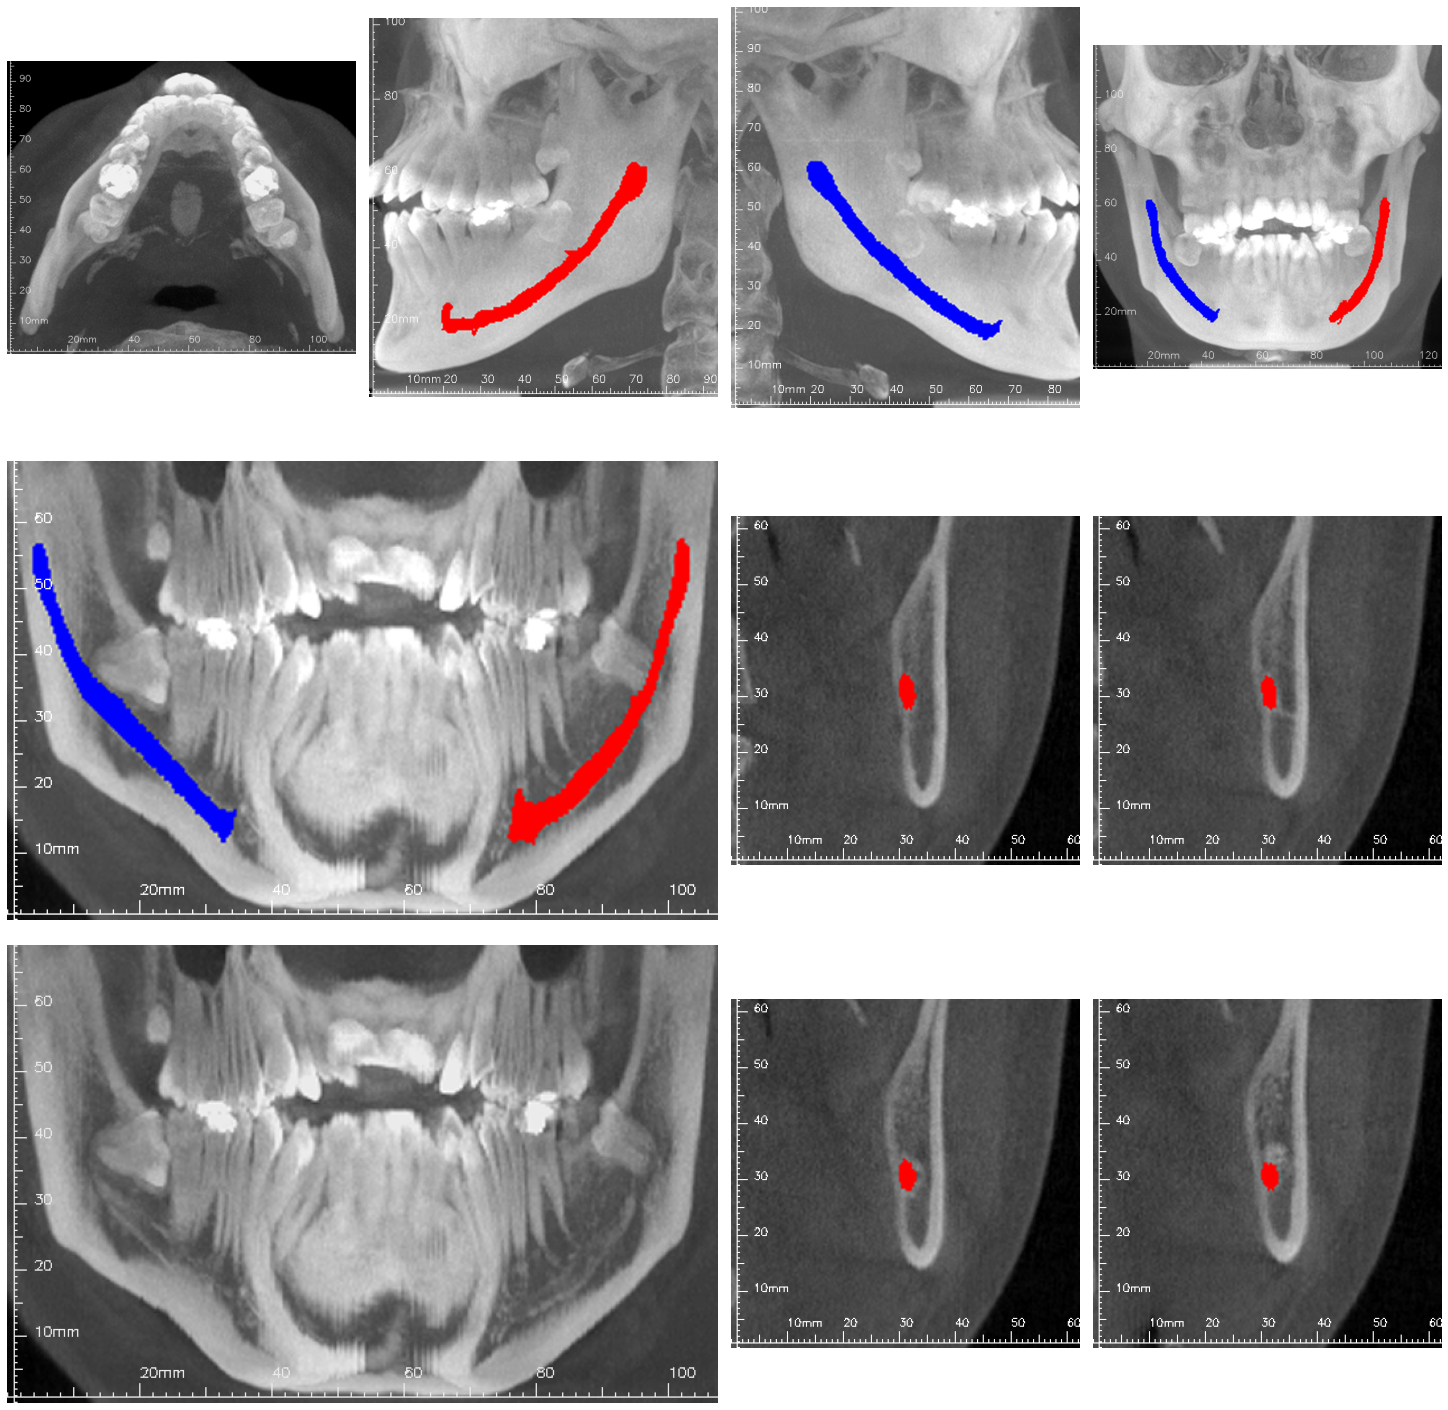

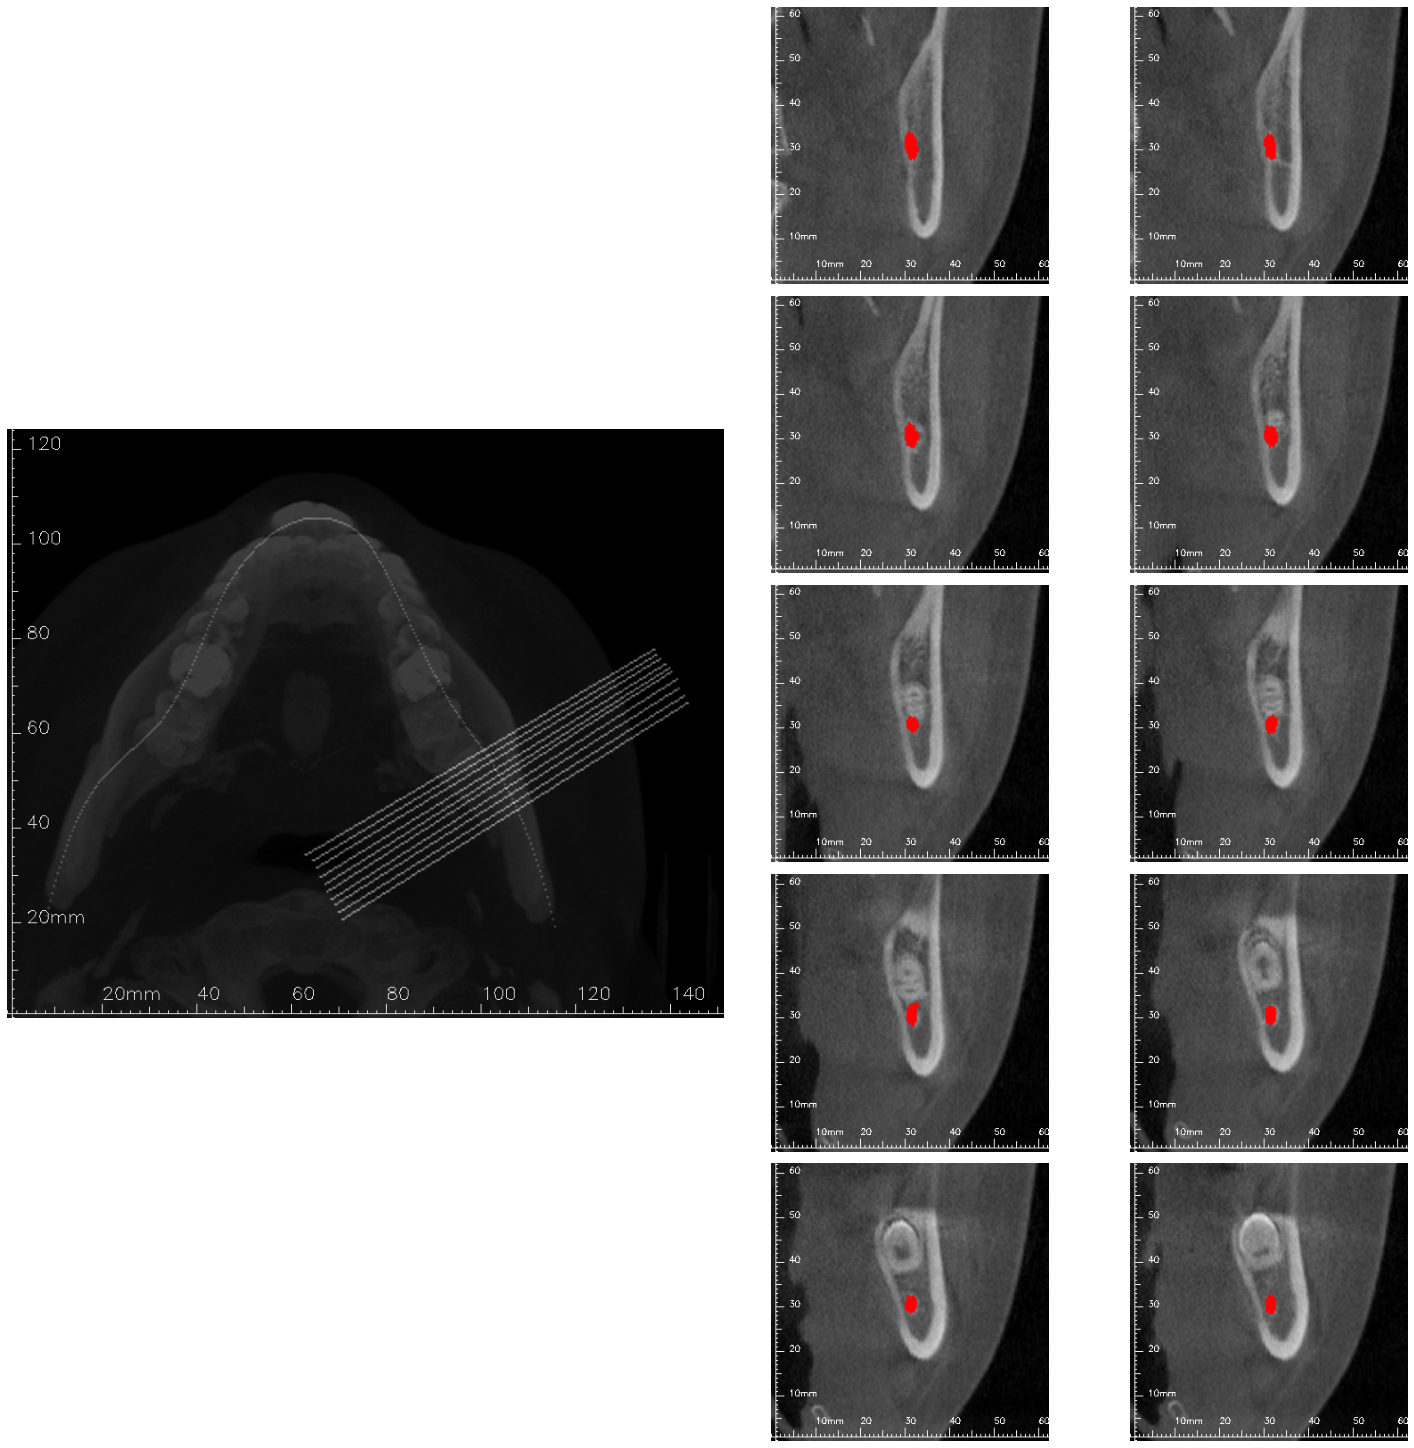

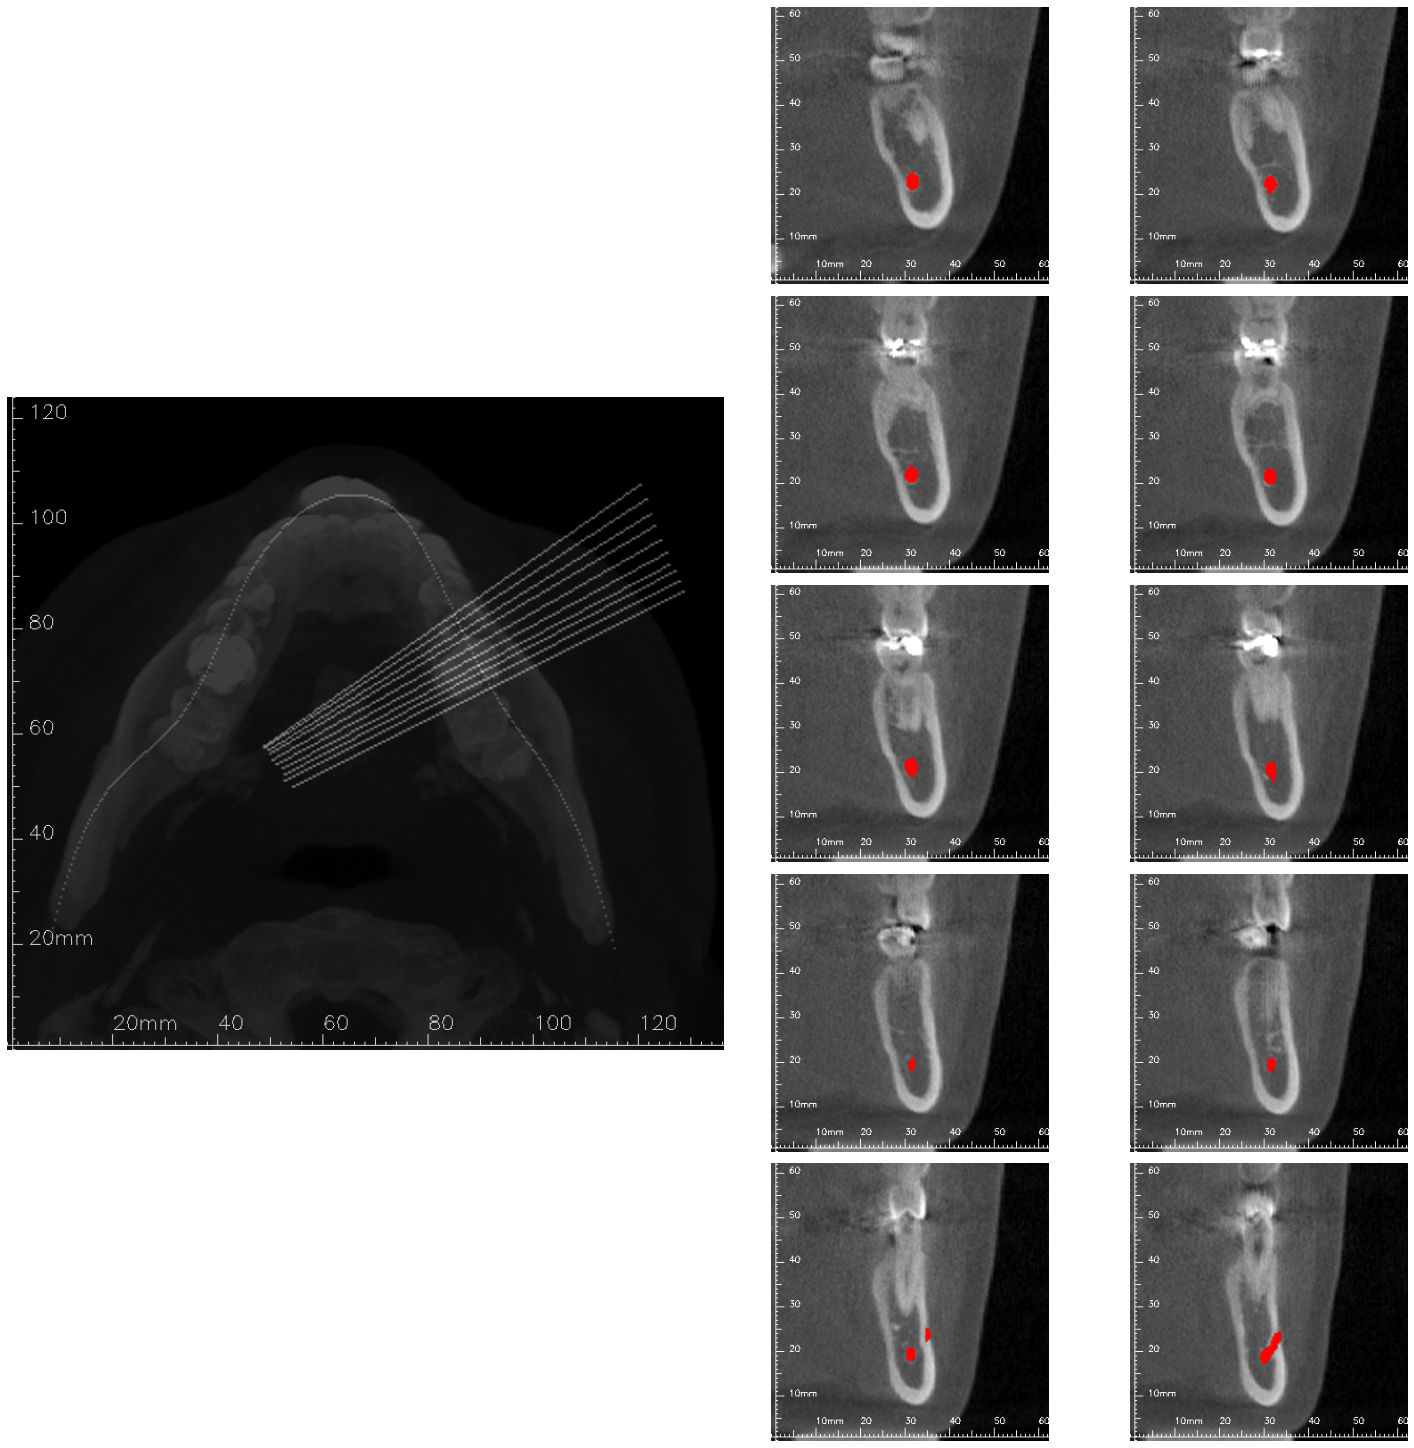

In [31]:
generate_report(pathscan)  ##This will create a new folder 'pdf_reports' in the current directory and save the resulting pdf report in it
